# Mueller Matrix Tutorial

In [14]:
import numpy as np, healpy as hp, matplotlib.pyplot as plt
import pygsm,time,copy
import pyuvdata.utils as uvutils
import operator,subprocess,argparse
import os,sys,glob,yaml
import json,itertools,shutil

import colorcet as cc
ccc = cc.m_cyclic_grey_15_85_c0_s25
import matplotlib
import cmocean

from astropy.coordinates import EarthLocation
from mpl_toolkits.axes_grid1 import AxesGrid
from astropy.io import fits
from matplotlib import gridspec
from astropy import wcs
from pyuvdata import UVData
from datetime import datetime
from collections import OrderedDict as odict
from astropy.time import Time
from astropy_healpix import HEALPix
from astropy.coordinates import SkyCoord, Galactic
from astropy import units as u
from astropy import constants as c
from copy import deepcopy
from sympy import *
init_printing(use_unicode=True)
from sympy.physics.quantum import TensorProduct


# Works only in python 2 env
sys.path.insert(0,'/Users/tashaleebillings/')
from cst2ijones.jones_matrix_field  import InstrumentalJonesMatrixField
from cst2ijones.plotting import PlotMueller
from cst2ijones import spherical_coordinates_basis_transformation as scbt

In [15]:
%matplotlib notebook

### Important Functions
These functions with the exception of txtname() are found in the imported module cst2ijones. I wrote them out explicitly here because I just want to see what's going on.

In [2]:
# given some frequency n, this function returns the proper file name.
def txtname(n):
    if n not in range(50,251):
        raise ValueError('no data at that frequency.')
    fname = '/Users/tashaleebillings/Desktop/data/NF_BEAM/HERA_4.9m_E-pattern_ {0}MHz.txt'.format(str(n))
    
    return fname

# Pauli Spin Matricies 
def StokesMatrix(n):
    if n not in [0,1,2,3]: raise Exception('Input must be an integer in [0,1,2,3]')
    
    if n == 0:
        p = np.array([[1.,0],[0.,1.]])
    elif n == 1:
        p = np.array([[1.,0],[0,-1.]])
    elif n == 2:
        p = np.array([[0,1.],[1.,0]])
    elif n == 3:
        p = np.array([[0., -1j],[1j,0]])
    
    return p

# Build Mueller Matrix elements from the pauli spin matrix given some jones matrix, J, at a certain frequency.
def MuellerMatrixElement(J,i,j):
    
    Pi = StokesMatrix(i)
    Pj = StokesMatrix(j)
    
    M_ij = np.einsum('...ab,...bc,...cd,...ad',Pi,J,Pj,J.conj()) / 2. #fancy way of taking the transpose
    
    M_ij = np.real(M_ij)
    
    return M_ij

def PlotMueller(jones):
    npix = jones.shape[0]
    nside = hp.npix2nside(npix)
    xsize = 1600
    reso = 120*180*np.sqrt(2.)/np.pi /(xsize-1)
    LambProj = hp.projector.AzimuthalProj(xsize=xsize,reso=reso, lamb=True, half_sky=True, rot=[0,30.72])
    p2v = lambda x,y,z: hp.vec2pix(nside,x,y,-z)
    
    logthresh = 4
    linscale = 2
    fig = plt.figure(figsize=(10,10))
    grid = AxesGrid(fig,(1,1,1),
                    nrows_ncols=(4,4),
                    axes_pad=(1.0,0.5),
                    label_mode='all',
                    share_all=False,
                    cbar_location='right',
                    cbar_mode='each',
                    cbar_size='5%',
                    cbar_pad='1%',
                    )
    for i in range(4):
        for j in range(4):
            M_ij = MuellerMatrixElement(jones, i, j)/2.
            img_d = LambProj.projmap(M_ij, p2v)
            
            if i == j == 0:
                cmap = 'viridis'
                vmin = 0
                vmax = 1
                                            
                tick_locs = list(np.linspace(0,1,7, endpoint=True))
                tick_labels = [r'$ < 10^{-6}$',
                               r'$10^{-5}$',
                               r'$10^{-4}$',
                               r'$10^{-3}$',
                               r'$10^{-2}$',
                               r'$10^{-1}$',
                               r'$10^{0}$']
                                                
            elif i != j:
                cmap='RdBu_r'
                vmin=-0.05
                vmax=0.05
                                                                
                d = np.log10(5) * np.diff(np.linspace(vmax*1e-6,vmax,7))[0]
                q = np.linspace(vmax*1e-6,vmax,7)[0::2] - d
                tick_locs = list(np.r_[-np.flipud(q)[:-1],[0], q[1:]])
                tick_labels = [r'$-10^{-2}$',
                               r'$-10^{-4}$',
                               r'$-10^{-6}$',
                               r'$< 5 \times 10^{-8}$',
                               r'$10^{-6}$',
                               r'$10^{-4}$',
                               r'$10^{-2}$']
                                                                    
            else:
                cmap=cmocean.cm.delta
                vmin=-1.
                vmax=1
                                                                                    
                q = np.linspace(vmax*1e-6, vmax,7)[0::2]
                tick_locs = list(np.r_[-np.flipud(q)[:-1],[0], q[1:]])
                tick_labels = [r'$-10^{0}$',
                               r'$-10^{-2}$',
                               r'$-10^{-4}$',
                               r'$< 10^{-6}$',
                               r'$10^{-4}$',
                               r'$10^{-2}$',
                               r'$10^{0}$']
            n = 4 * i + j
            im = grid[n].imshow(img_d, interpolation='none',
                                cmap=cmap,
                                aspect='equal',
                                vmin=vmin,
                                vmax=vmax,)
                                                                                                                
            grid[n].set_xticks([])
            grid[n].set_yticks([])
            
            cbar = grid.cbar_axes[n].colorbar(im, ticks=tick_locs)
            grid.cbar_axes[n].set_yticklabels(tick_labels)
            
            im.set_norm(matplotlib.colors.SymLogNorm(10**-logthresh,linscale, vmin=vmin,vmax=vmax))
        plt.tight_layout(w_pad=0.5, h_pad=1.0)
        #plt.savefig('full_mueller_example.png', dpi=80, bbox_inches='tight')
        #plt.savefig('full_mueller_150MHz.pdf', bbox_inches='tight')
        #plt.close(plt.gcf())
        plt.show()

In [21]:
R_z0

array([[-0.51086554,  0.        , -0.85966063],
       [ 0.        ,  1.        ,  0.        ],
       [ 0.85966063,  0.        , -0.51086554]])

nu0 =  110
('Nu axis', array([109., 110., 111.]))
Setting interpolant.


<IPython.core.display.Javascript object>


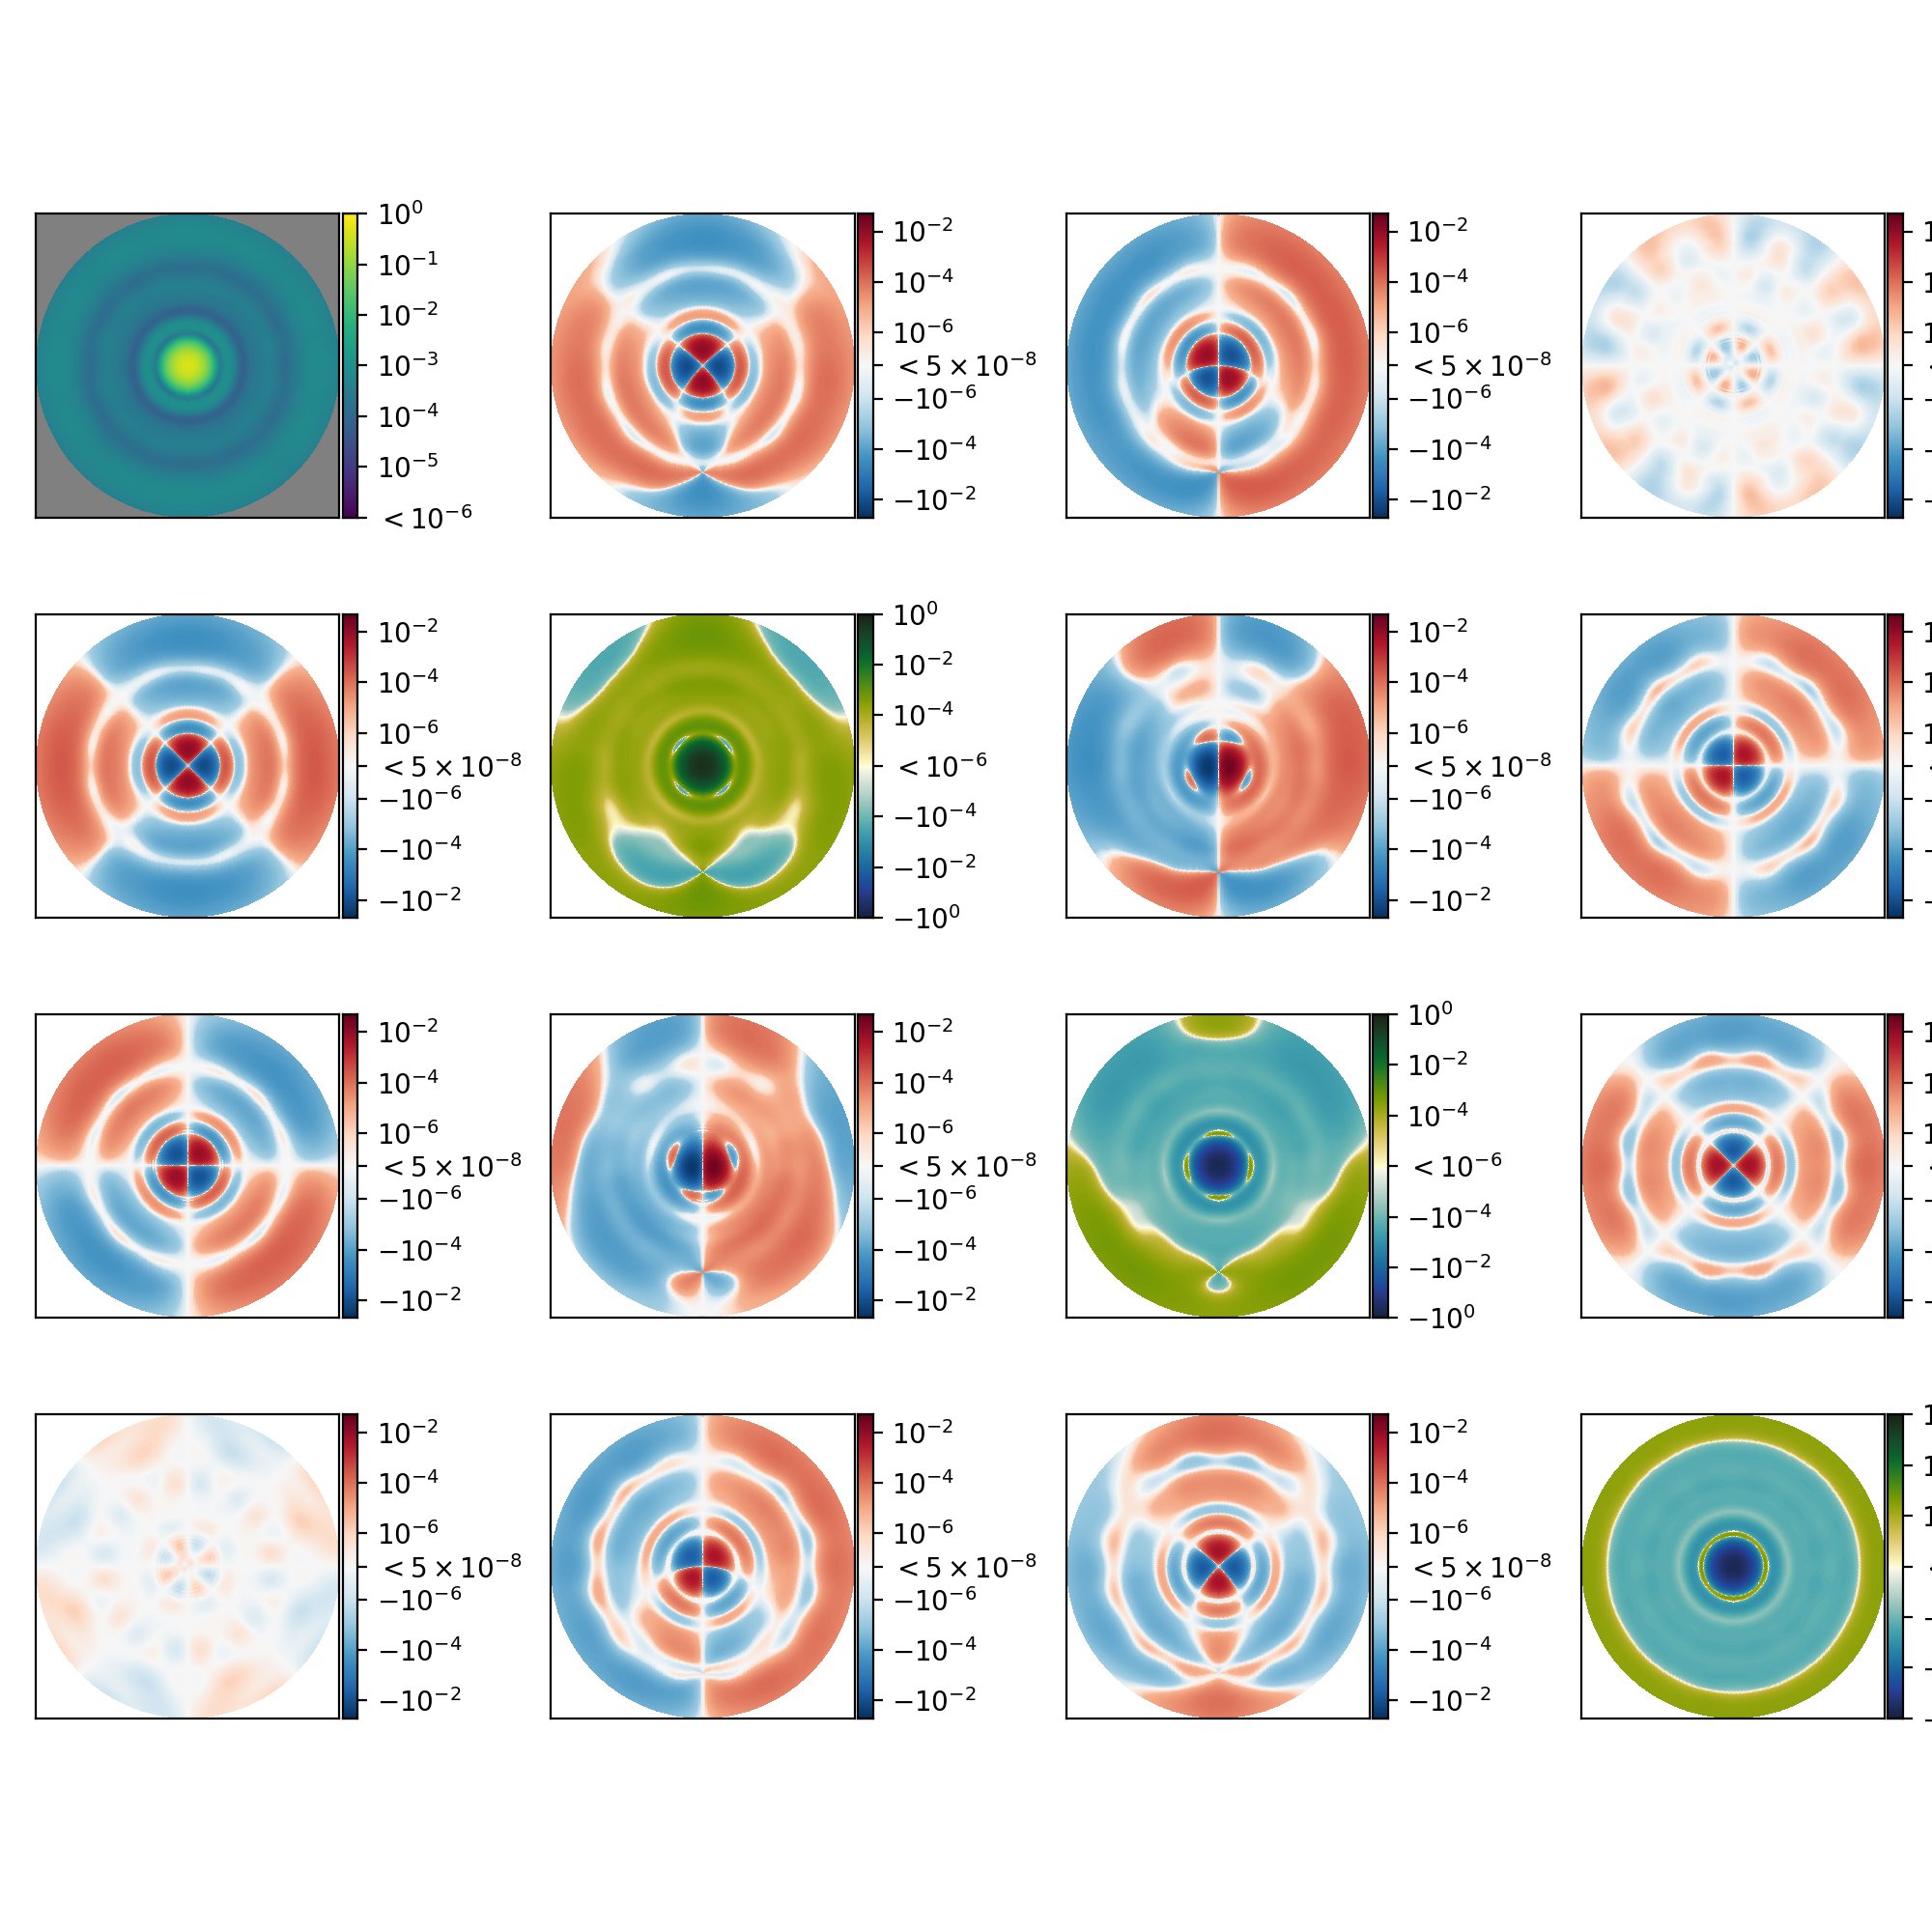

/Users/tashaleebillings/anaconda3/envs/hera2/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


In [4]:
for nu0 in range(110,130,20):
    print "nu0 = ", nu0
    nu_nodes = range(nu0-5,nu0+6)
    
    input_files = [txtname(n) for n in nu_nodes]
    
    iJMF = InstrumentalJonesMatrixField(input_files, nu_nodes)
    
    z0_cza = np.radians(120.7215)
    z0 = scbt.r_hat(z0_cza, 0.)
    
    RotAxis = np.array([0,-1,0])
    RotAngle = z0_cza
    
    R_z0 = scbt.rotation_matrix(RotAxis, RotAngle)
    
    nside = 128
    npix = hp.nside2npix(nside)
    hpxidx = np.arange(npix)
    dH, aH = hp.pix2ang(nside, hpxidx)
    thH, phiH = scbt.spherical_coordinates_map(R_z0, dH, aH)
    phiH = 2.*np.pi - phiH
    
    nu_axis = np.linspace(nu0-1.,nu0+1., 3, endpoint=True)
    print("Nu axis", nu_axis)
    
    ijones = iJMF(nu_axis, thH, phiH, R_z0.T)
    
    ijones[:,:,:,0] *= -1.
    
    PlotMueller(ijones[1])
    
    # plt.savefig('VivaldiPlots/{}MHz.png'.format(nu0), dpi=80, bbox_inches='tight')
    # plt.savefig('SinuousPlots/{}MHz.png'.format(nu0), dpi=80, bbox_inches='tight')
    plt.savefig('/Users/tashaleebillings/Desktop/research/images/full_mueller_example.png')
    #plt.show()
    #plt.close(plt.gcf())

Dim and shape of iJones matrix 5 (6, 512, 512, 2, 2)


<IPython.core.display.Javascript object>


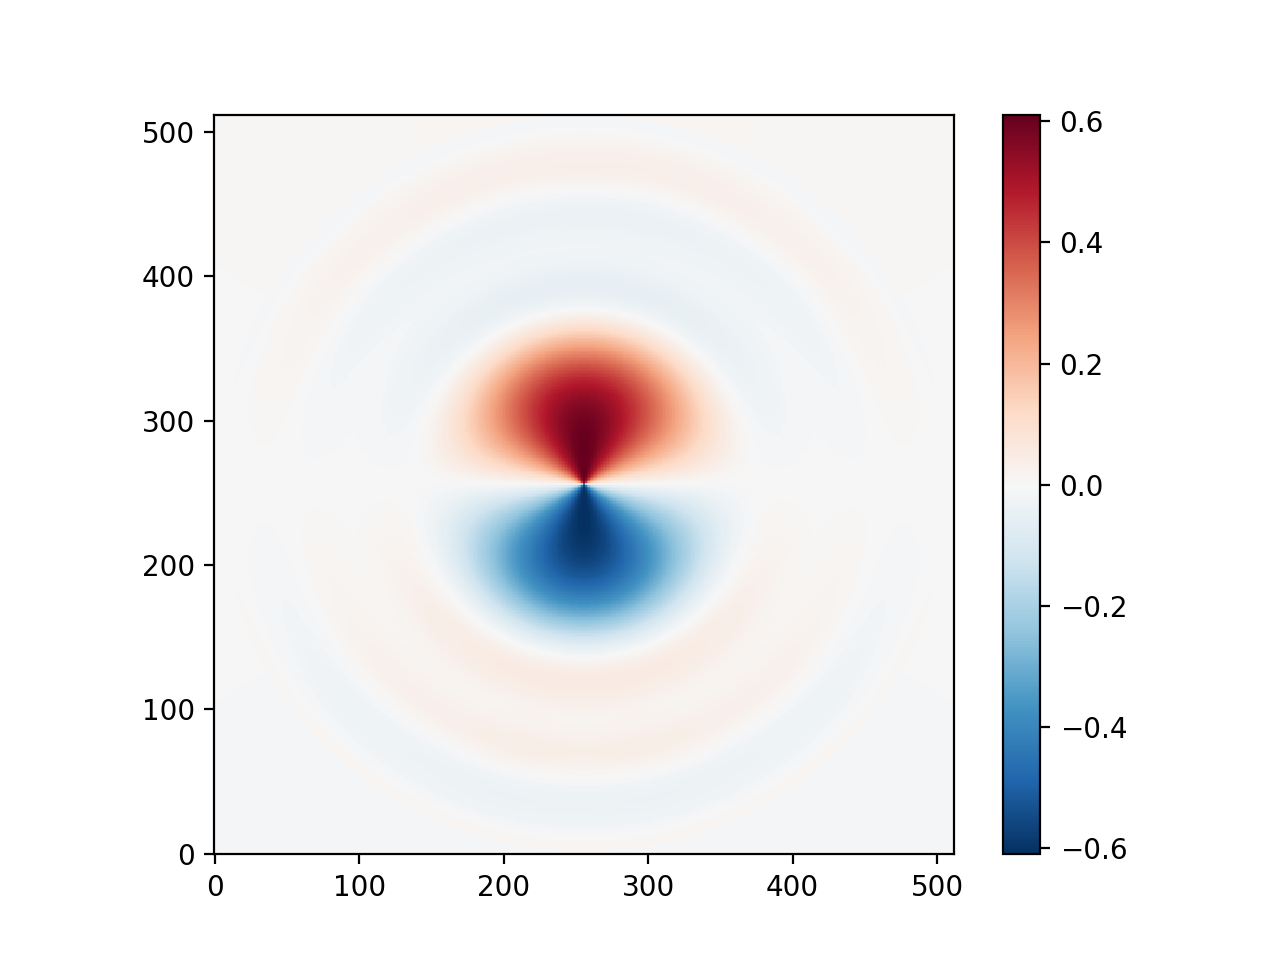

<IPython.core.display.Javascript object>


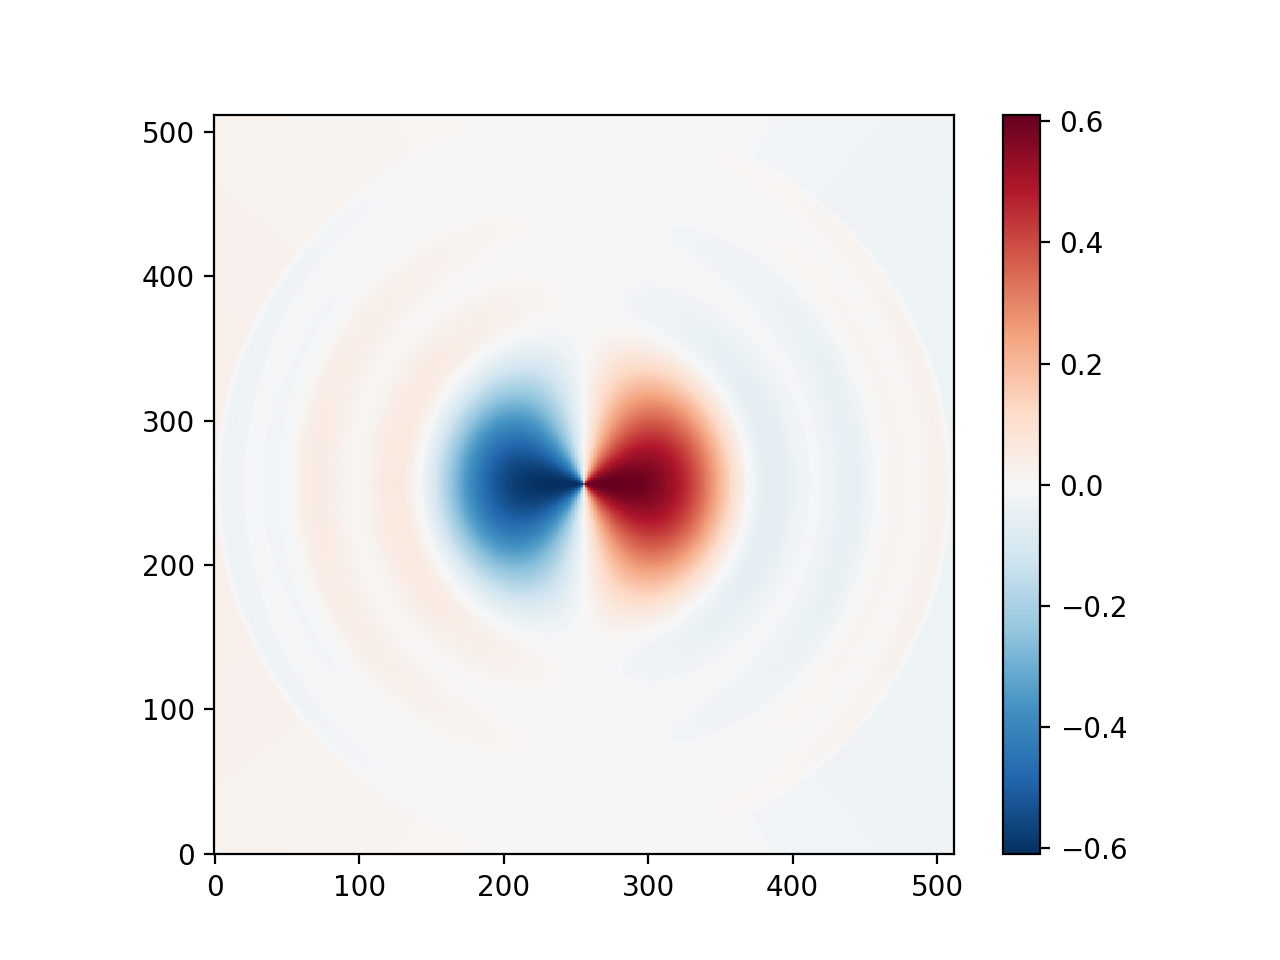

<IPython.core.display.Javascript object>


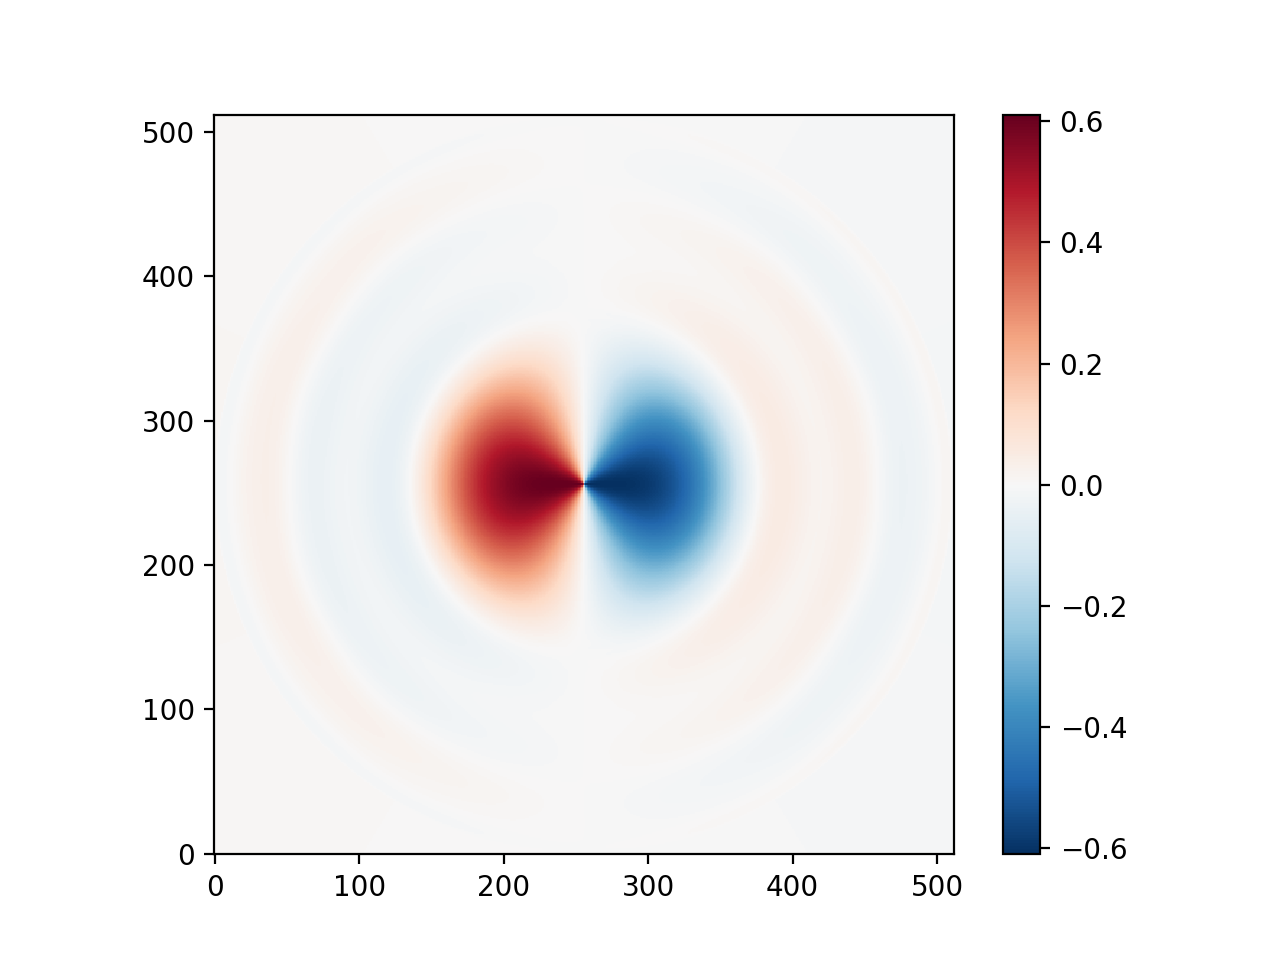

<IPython.core.display.Javascript object>


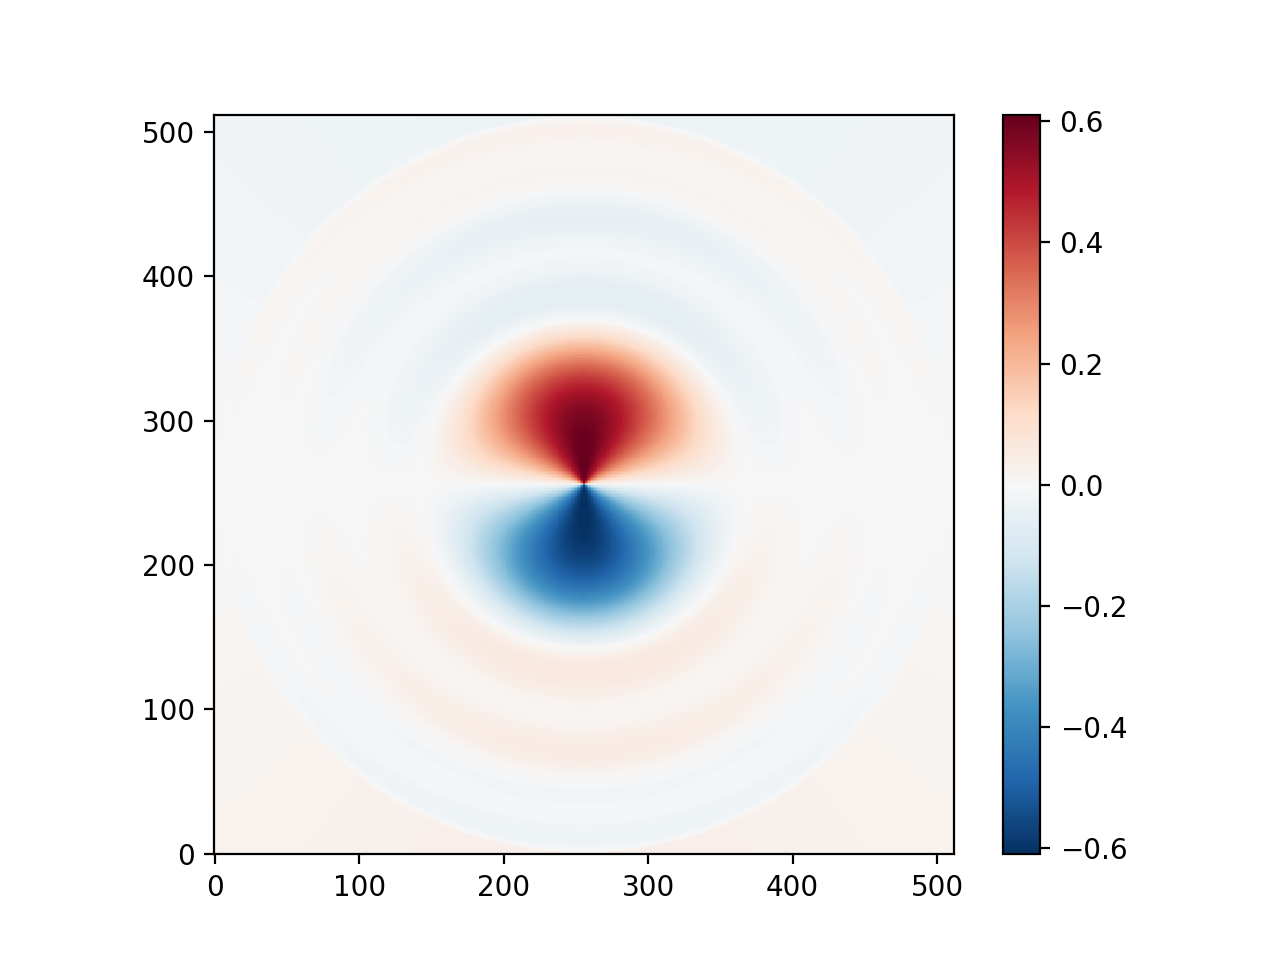

In [19]:
# Modification of Zac's cst2jone_test.py
# You will need Nick Fangnoni's cst files
"""
Build Mueller matrix as a function of frequency from Nick Fangnoni's cst component list 
of Radiation Patterns/E-Field Patterns.
"""

def txtname(n):
    if n not in range(50,251):
        raise ValueError('no data at that frequency.')
    fname = '/Users/tashaleebillings/Desktop/data/NF_BEAM/HERA_4.9m_E-pattern_ {0}MHz.txt'.format(str(n))
    
    return fname

file_freqs = range(145,155) # List of frequencies for each file
input_files = [txtname(n) for n in file_freqs] # List of files at a frequency

# Initializing the direction-dependent Jones matrix for a dipole feed 
J = InstrumentalJonesMatrixField(input_files, file_freqs, use_multiprocessing=False)

# Build Rotation Matrix
z0_cza = np.radians(120.7215)
z0 = scbt.r_hat(z0_cza, 0.) # Join a sequence of arrays along a 0 axis

RotAxis = np.array([0,-1,0]) # rotation along y-axis
RotAngle = z0_cza

R_z0 = scbt.rotation_matrix(RotAxis, RotAngle)

# Frequency Steps to interpolate
df = 0.0977517106549 #MHz
nu_axis = np.array([148.87585533, 148.97360704, 149.07135875,
           149.16911046, 149.26686217, 149.36461388])#np.linspace(149.,151.,6,endpoint=True)
J.set_interpolant(nu_axis)

# Determine the proper theta (rad) and phi (rad) values for a Sky Coordinate 
# value at a specific HealPix pixel value.
pixnum = 512

arcsec = 500.
arcsec2deg = 2#arcsec/3600.

# Build pixel axis
l_axis = np.linspace(-arcsec2deg/2,arcsec2deg/2,pixnum, endpoint=True)# l=cos(phi)sin(theta)
m_axis = np.linspace(-arcsec2deg/2,arcsec2deg/2,pixnum, endpoint=True)# m=sin(phi)sin(theta)

# Create Meshgrid from the pixels to represent equatorial coordinates
ll_grid, mm_grid = np.meshgrid(l_axis, m_axis, indexing='xy')

# Use Trig to express phi and theta as a function of Sky Coordinates
rr2_grid = np.power(ll_grid, 2) + np.power(mm_grid, 2) # = (Sin(theta))**2, limits [0,1]

nn_grid = np.zeros_like(ll_grid) # dim[512,512]=[pixnum,pixnum]
nn_grid[rr2_grid < 1.] = np.sqrt(1. - rr2_grid[rr2_grid < 1.]**2.)# =cos(theta), limits [-1,1]

# don't use ravel because altering the values could change the original data.
nn_flat = nn_grid.flatten()

th_use = np.arccos(nn_flat[nn_flat < 1.])# Theta values, limits [0,np.pi] it is the polar angle

phi_grid = np.arctan2(mm_grid, ll_grid)
fix_phi = np.where(phi_grid < 0.)[0]
phi_grid[fix_phi] = 2*np.pi + phi_grid[fix_phi]
phi_grid[nn_grid >= 1.] = np.nan
phi_use = (phi_grid.flatten())[nn_flat < 1.]# Phi values, limits [0, 2*np.pi] it is the azimuthal angle

#Interpolate Beam [freq, total Npixels, Row_jones_matrix, Colu_jones_matrix]
R_id = np.eye(3) #Return a 2-D array with ones on the diagonal and zeros elsewhere
ijones = J(nu_axis, th_use, phi_use, R_id)

# reshape jones matrix cube to make an image with dim[freq,pixnum,pixnum, 2x2 jones matrix]
ijones_flat = np.zeros((len(nu_axis),pixnum**2, 2, 2), dtype=np.complex)
ijones_flat[:, nn_flat < 1., :, :] = ijones
# At a certain frequency each pixel has a 2x2 jones matrix
ijones_img = np.reshape(ijones_flat, (len(nu_axis),pixnum, pixnum, 2, 2))
print "Dim and shape of iJones matrix", ijones_img.ndim, ijones_img.shape

plt.figure()
plt.imshow(np.real(ijones_img[2,:,:,0,0].T), origin='lower', cmap='RdBu_r')
plt.colorbar()

plt.figure()
plt.imshow(np.real(ijones_img[2,:,:,0,1].T), origin='lower', cmap='RdBu_r')
plt.colorbar()

plt.figure()
plt.imshow(np.real(ijones_img[2,:,:,1,0].T), origin='lower', cmap='RdBu_r')
plt.colorbar()

plt.figure()
plt.imshow(np.real(ijones_img[2,:,:,1,1].T), origin='lower', cmap='RdBu_r')
plt.colorbar()
plt.show()

# New Version: Make Mueller Beam

Use Astropy To Determine Grid and Making Simulated Interpolated Jones Matrix at 6 frequencies between 145-155 MHz

In [16]:
def txtname(n):
    if n not in range(50,251):
        raise ValueError('no data at that frequency.')
    fname = '/Users/tashaleebillings/Desktop/data/NF_BEAM/HERA_4.9m_E-pattern_ {0}MHz.txt'.format(str(n))
    
    return fname
def StokesMatrix(n):
    if n not in [0,1,2,3]: raise Exception('Input must be an integer in [0,1,2,3]')
    
    if n == 0:
        p = np.array([[1.,0],[0.,1.]])
    elif n == 1:
        p = np.array([[1.,0],[0,-1.]])
    elif n == 2:
        p = np.array([[0,1.],[1.,0]])
    elif n == 3:
        p = np.array([[0., -1j],[1j,0]])
    
    return p

def MuellerMatrixElement(J,i,j):
    
    Pi = StokesMatrix(i)
    Pj = StokesMatrix(j)
    
    M_ij = np.einsum('...ab,...bc,...cd,...ad',Pi,J,Pj,J.conj()) / 2.
    
    M_ij = np.real(M_ij)
    
    return M_ij

def image_multiplication(left_image,right_image): #left_image*right_image
    # This function multiplies images together per frequency. 
    #The images should have a shape (row, col, ra_pix, dec_pix). 
    
    result = [[sum(a*b for a,b in zip(left_image_row,right_image_col)) for right_image_col in zip(*right_image)] for left_image_row in left_image]
    result_array = np.array(result)

    return np.array(result_array)

def pbcorrdata(beamdata,modeldata, frequency):
    results = np.zeros((4,512,512))
    freq = frequency

    # iterate through rows of X
    for i in range(len(modeldata)):
       # iterate through columns of Y
       for j in [0]:
           # iterate through rows of Y
           for k in range(len(modeldata)):
               results[i,:,:] += beamdata[i,k,freq,:,:] * modeldata[k,freq,:,:]
    return results

# Build Matrix
i = 1j
i_index,j_index = 4,4
npix = 512

# Initialize Matrix image
# I is the idenity matrix, T converts coherency vector/matrix to Pseudo-Stokes vector/matrix
# S in the conj. inverse of T
I = np.zeros((i_index,j_index,npix,npix),dtype=np.float64) #np.matrix([[1.,0.,0.,0.],[0.,1.,0.,0.],[0.,0.,1.,0.],[0.,0.,0.,1.]])
T = np.zeros((i_index,j_index,npix,npix),dtype=np.complex64) #np.matrix([[1.,0.,0.,1.],[1.,0.,0., -1.],[0.,1.,1., 0.],[0.,-i,i,0.]])
S = np.zeros((i_index,j_index,npix,npix),dtype=np.complex64) #T.inverse # np.matrix([[0.5,0.5,0.,0.],[0.,0.,0.5,0.5*i],[0.,0.,0.5,-0.5*i],[0.5,-0.5,0.,0.]])

# Fill in image
I[0,0,:,:] = 1.
I[1,1,:,:] = 1.
I[2,2,:,:] = 1.
I[3,3,:,:] = 1.

T[0,0,:,:], T[0,3,:,:] = 1., 1.
T[1,0,:,:], T[1,3,:,:] = 1., -1.
T[2,1,:,:], T[2,2,:,:] = 1., 1.
T[3,1,:,:], T[3,2,:,:] = -i, i

S[0,0,:,:], S[0,1,:,:] = 0.5, 0.5
S[1,2,:,:], S[1,3,:,:] = 0.5, 0.5*i
S[2,2,:,:], S[2,3,:,:] = 0.5, -0.5*i
S[3,0,:,:], S[3,1,:,:] = 0.5, -0.5
    

In [17]:
nu0 = 110
print "nu0 = ", nu0
nu_nodes = range(nu0-5,nu0+6)

input_files = [txtname(n) for n in nu_nodes]

J = InstrumentalJonesMatrixField(input_files, nu_nodes)

lat = 120.7215 # units of degrees. Remember it runs from [90,-90] so 120deg == -30deg
z0_cza = np.radians(lat) # theta on the sphere is the polar angle
z0 = scbt.r_hat(z0_cza, 0.) # directional vector on sphere (sin(theta)cos(phi),sin(theta)sin(phi),cos(theta))

RotAxis = np.array([0,-1,0])
RotAngle = z0_cza

R_z0 = scbt.rotation_matrix(RotAxis, RotAngle)

nside = 128
npix = hp.nside2npix(nside)
hpxidx = np.arange(npix)
dH, aH = hp.pix2ang(nside, hpxidx)
thH, phiH = scbt.spherical_coordinates_map(R_z0, dH, aH)
phiH = 2.*np.pi - phiH

nu_axis = np.linspace(nu0-1.,nu0+1., 3, endpoint=True)

ijones = J(nu_axis, thH, phiH, R_z0.T)

nside_ = 512#128
npix_ = hp.nside2npix(nside_)
ipix_ = np.arange(npix_)
theta_, phi_ = hp.pix2ang(nside_, ipix_)
thH_, phiH_ = scbt.spherical_coordinates_map(R_z0, theta_, phi_)
phiH = 2.*np.pi - phiH
#test_jones = iJMF(nu_axis, thH, phiH, R_z0.T)
test_jones = J(nu_axis, thH_, phiH_, R_z0.T)

nu0 =  110
Setting interpolant.


#### BUILD PROPER GRID SIZE
Determine the proper theta (rad) and phi (rad) values for a Sky Coordinate.
Value at a specific HealPix pixel value.

In [18]:
# BUILD PROPER GRID SIZE
# Determine the proper theta (rad) and phi (rad) values for a Sky Coordinate
# value at a specific HealPix pixel value.
fitsobject = "/Users/tashaleebillings/Desktop/data/gc.2457548.uvcRP.forceQUV2zero_Interactive.image.fits"

# Load the FITS hdulits
data, header = fits.getdata(fitsobject, header=True)

# Parse the WCS keywords in the primary HDU
w = wcs.WCS(header)

npix_sq = 512

# Convert Equitorial Coordinates to Spherical Coordinates grid
xpix, ypix = np.meshgrid(np.arange(npix_sq),np.arange(npix_sq), indexing='xy')#np.meshgrid(np.arange(1,npix+1),np.arange(1,npix+1), indexing='xy')
ra, dec, dummy_freq, dummy_stokes = w.all_pix2world(xpix, ypix,1,1,1) #Right ascension and declination as seen on the inside of the celestial sphere
c_icrs = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs') # Coordinates Object

# Convert ra/dec to phi/theta
# don't use ravel because altering the values could change the original data.
theta_grid = np.pi/2. - c_icrs.dec.radian 
theta_flat = np.reshape(theta_grid,-1)

#phi_grid = np.radians(header['CRVAL1']) - c_icrs.ra.radian # azimuthal angle limits [0,2*np.pi]
phi_grid = c_icrs.ra.radian.mean() - c_icrs.ra.radian
phi_flat = np.reshape(phi_grid,-1)

# Calculate rotation around -y (?) to get the beam to point at declination = latitude
z0_cza = np.radians(120.7215)
RotAxis = np.array([0,-1,0])
RotAngle = z0_cza
R_z0 = scbt.rotation_matrix(RotAxis, RotAngle)

In [19]:
theta_flat

array([2.45629503, 2.45873173, 2.46115009, ..., 1.26913385, 1.26761503,
       1.26608017])

<IPython.core.display.Javascript object>


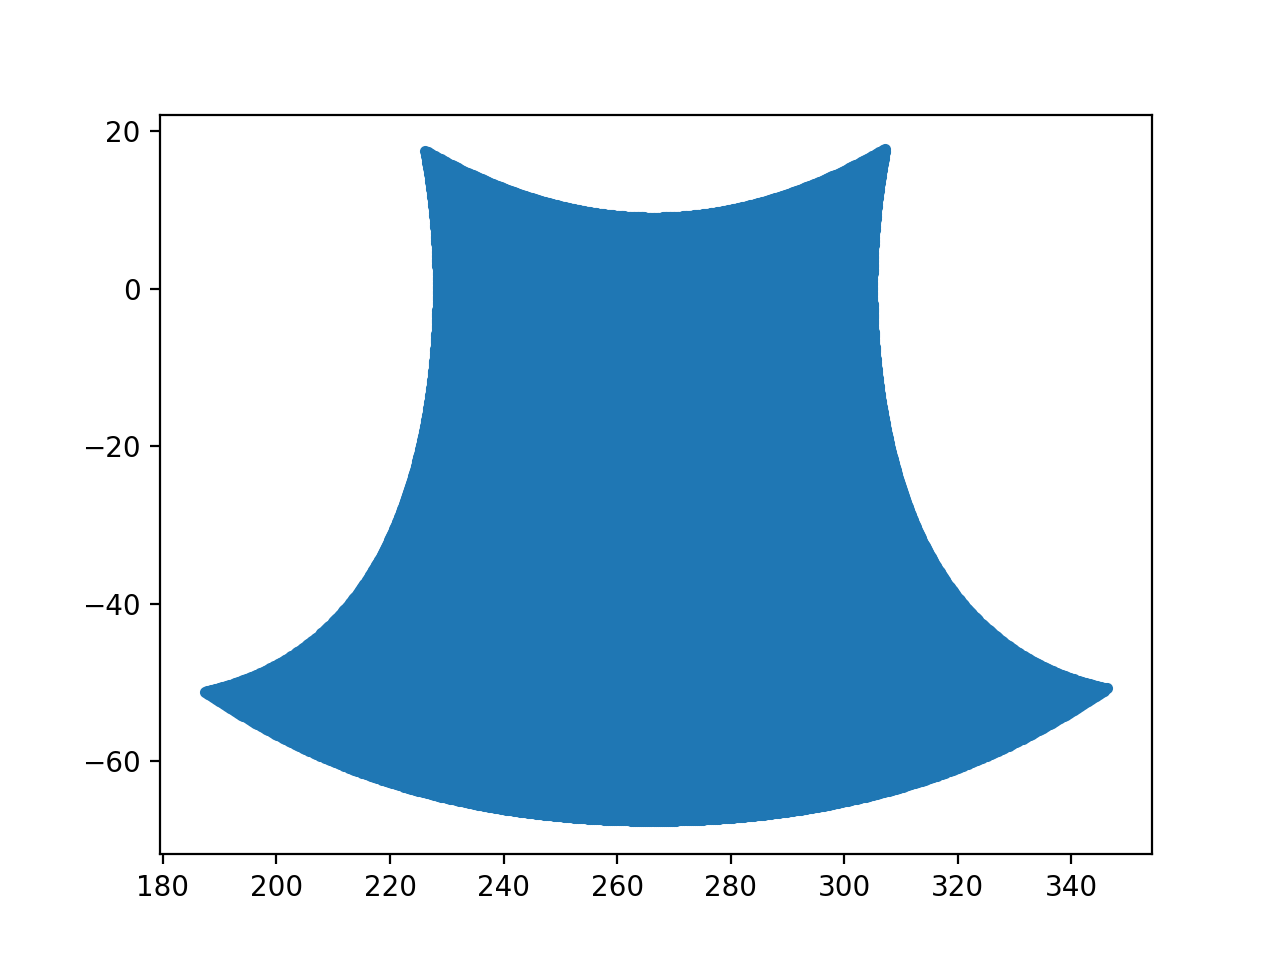

<IPython.core.display.Javascript object>


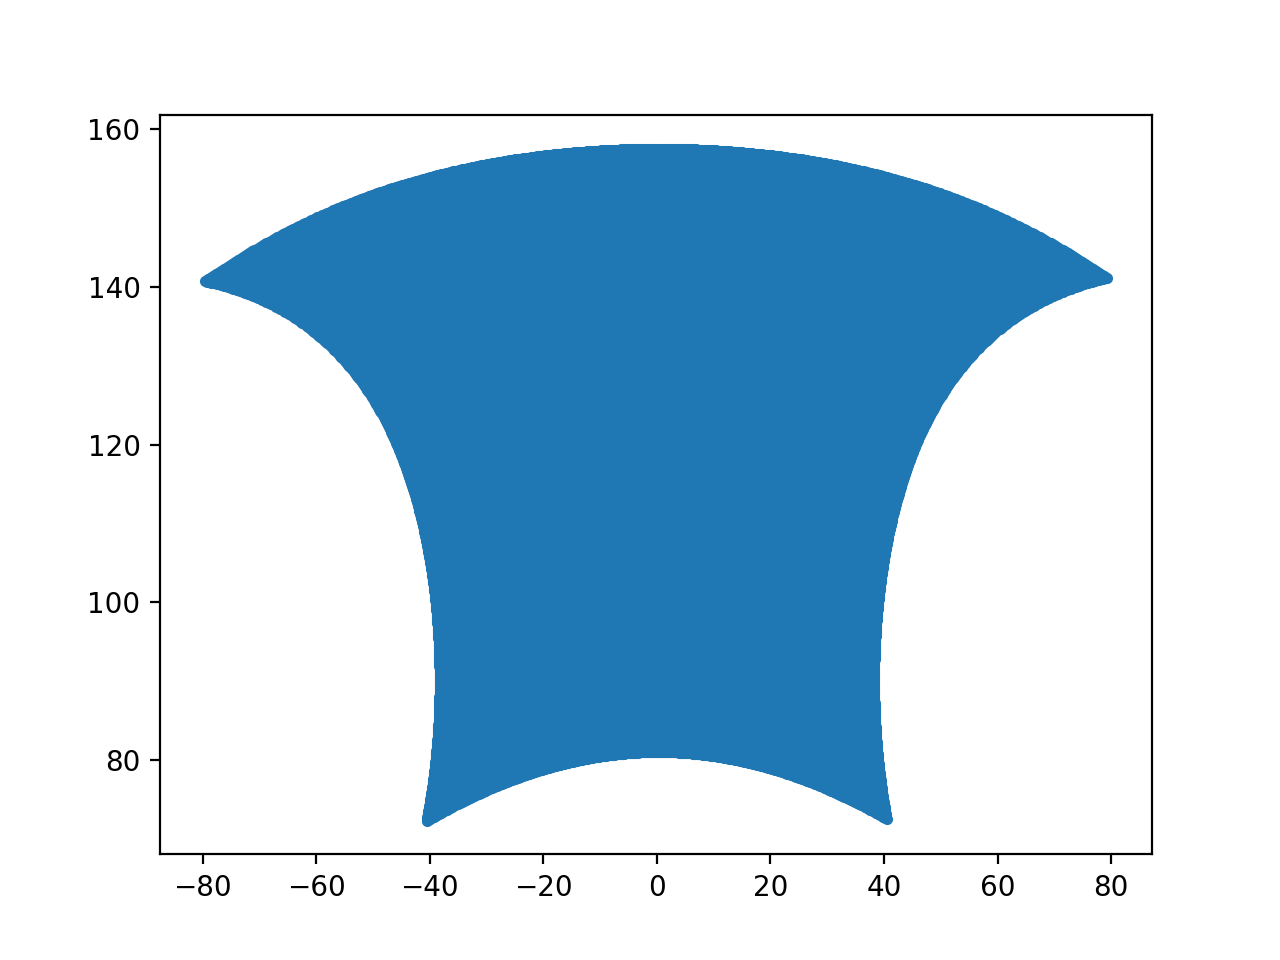

In [20]:
# Check that we have reasonable RA and DEC values
plt.figure()
plt.plot(ra.flatten(),dec.flatten(),'.')
plt.show()

plt.figure()
plt.plot(np.degrees(phi_flat),np.degrees(theta_flat),'.')
plt.show()

<IPython.core.display.Javascript object>


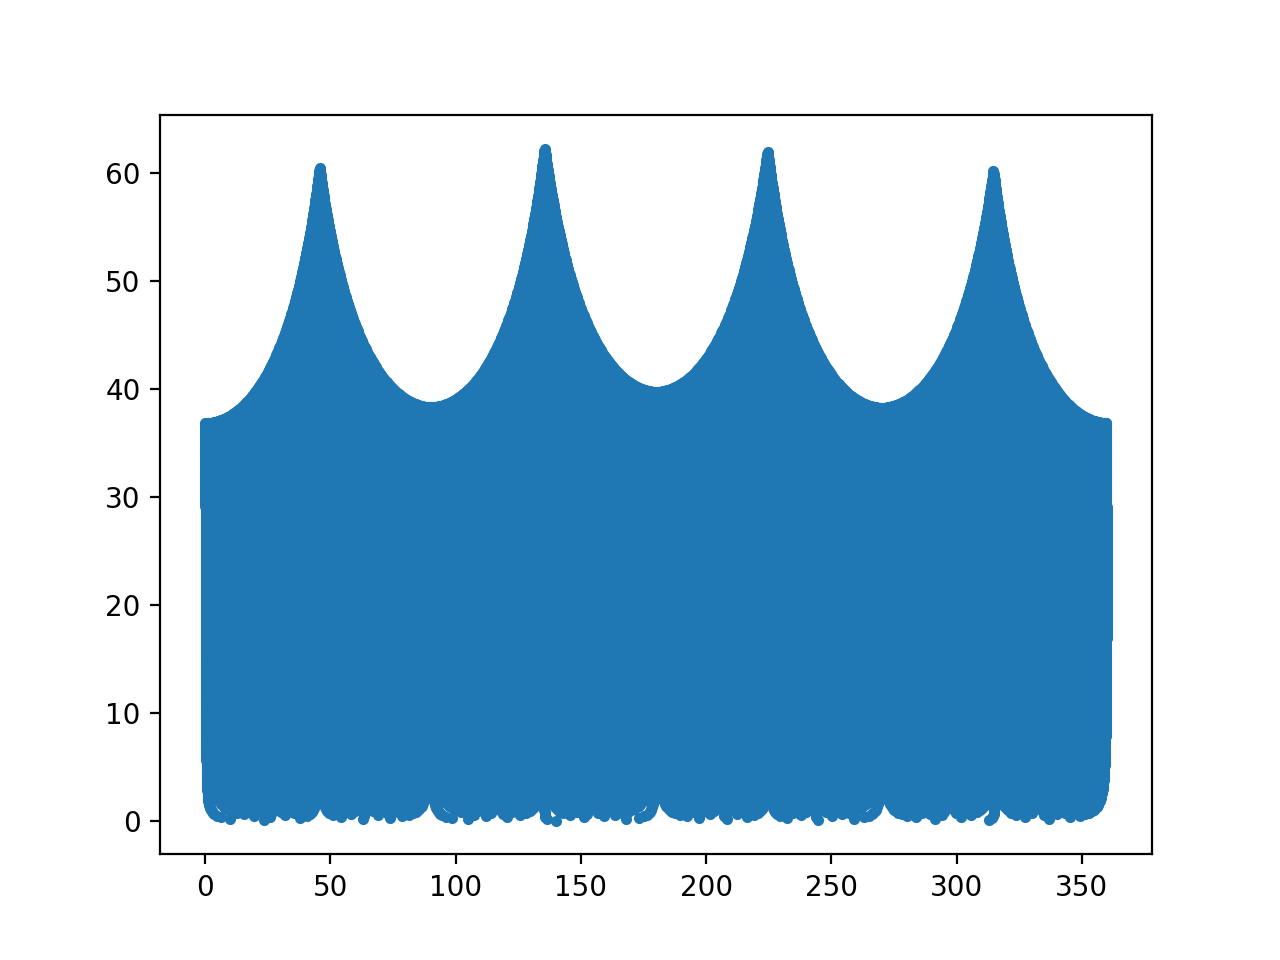

In [11]:
plt.figure()
plt.plot(np.degrees(phi_hor),np.degrees(theta_hor),'.')
plt.show()

### Jones Beam 
This is what the beam looks like when we rotate the beam theta = ~120 degrees (polar angle)

<IPython.core.display.Javascript object>


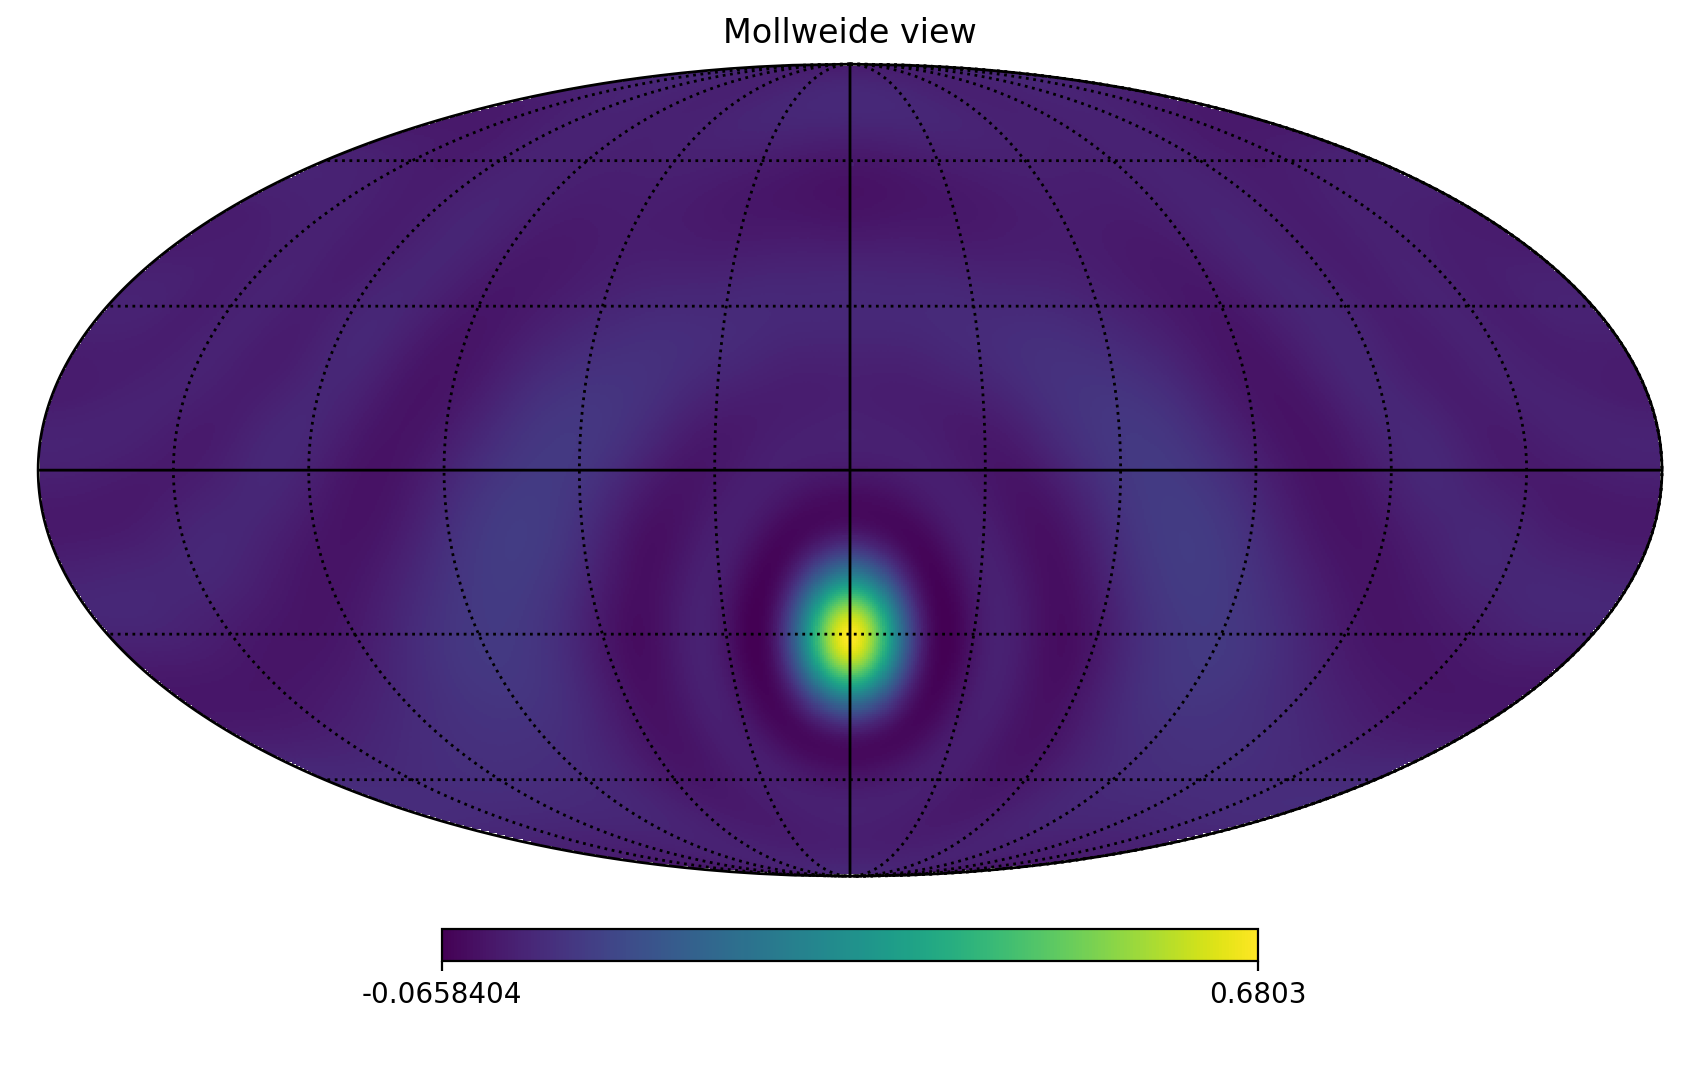

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


/Users/tashaleebillings/anaconda3/envs/hera2/lib/python2.7/site-packages/healpy/projector.py:201: ComplexWarning: Casting complex values to real discards the imaginary part
  img[w] = mpix


<IPython.core.display.Javascript object>


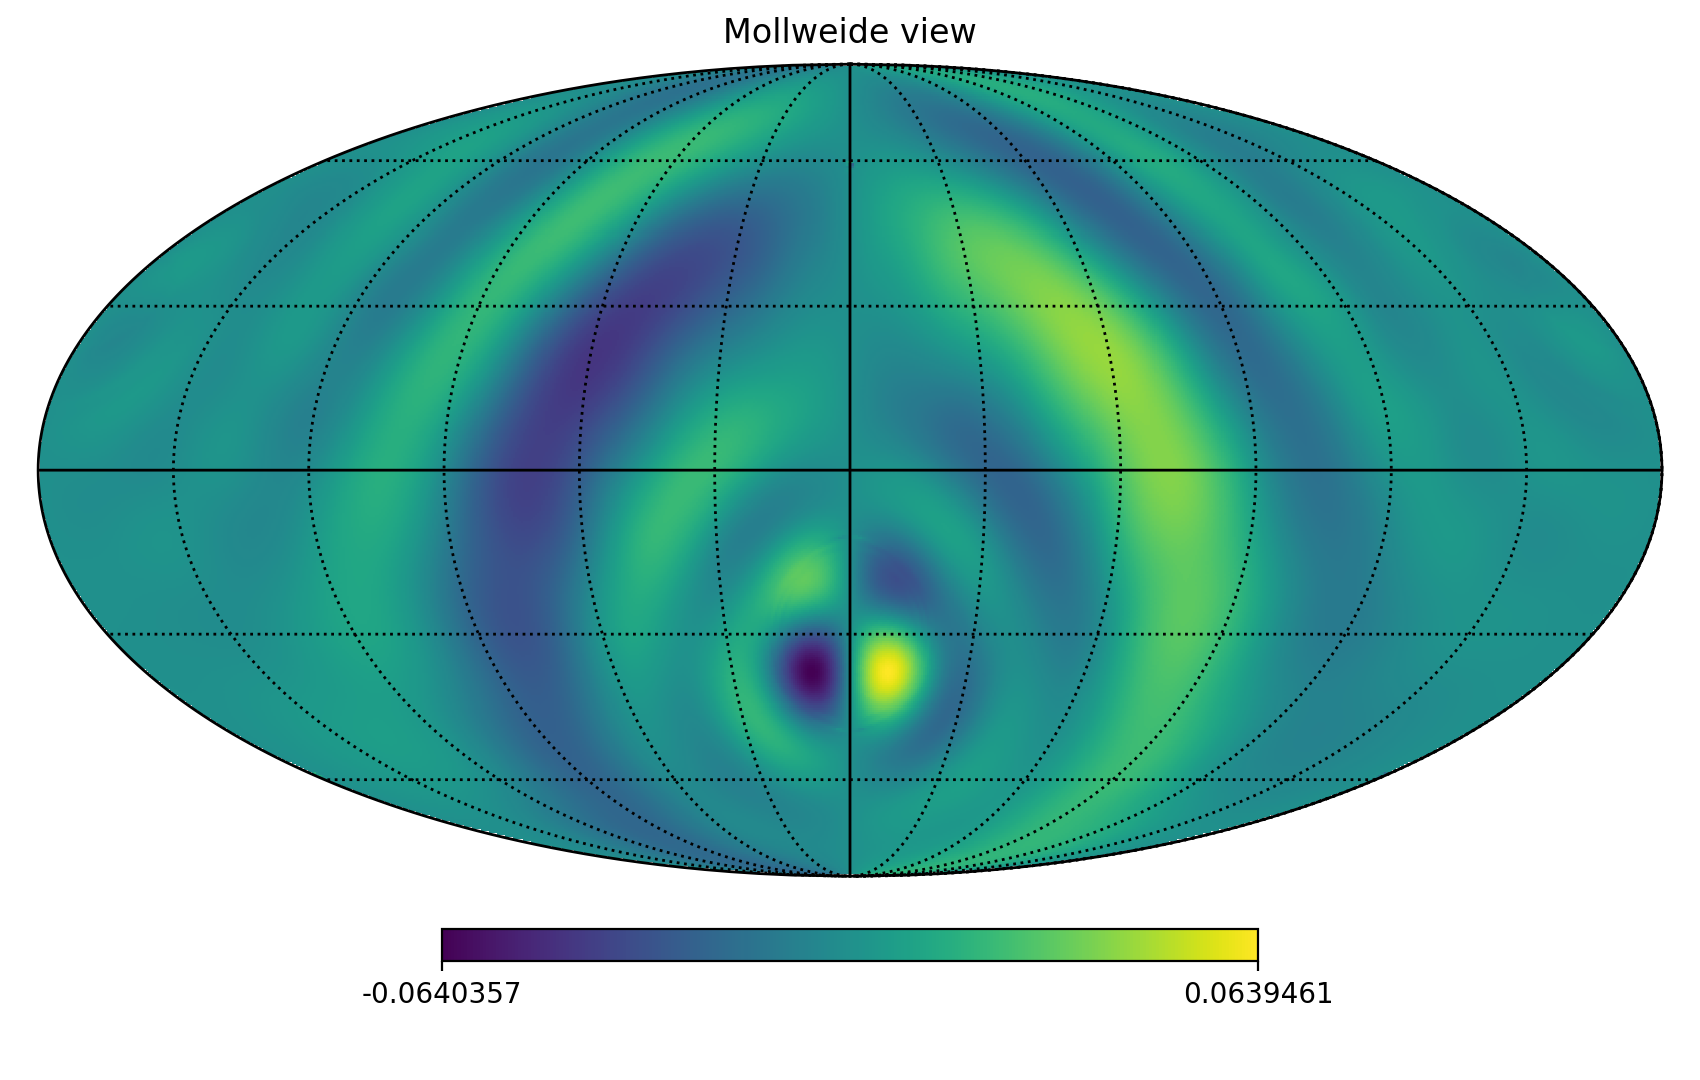

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


<IPython.core.display.Javascript object>


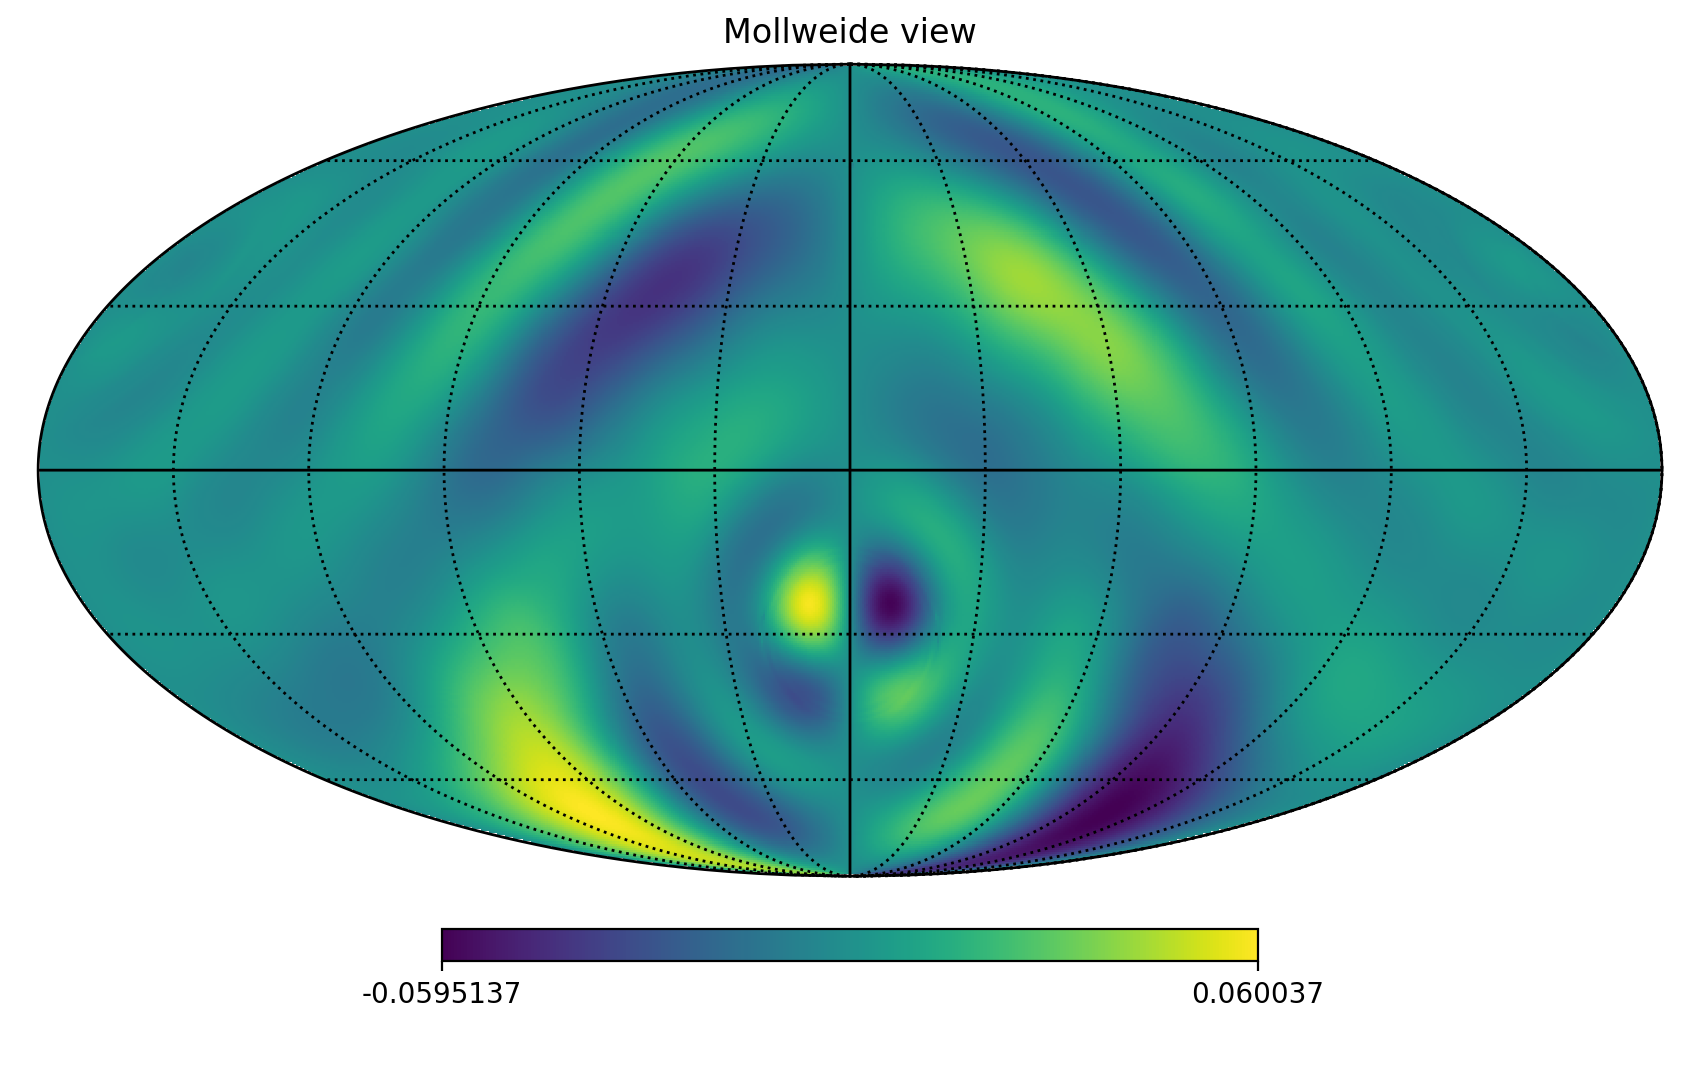

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


<IPython.core.display.Javascript object>


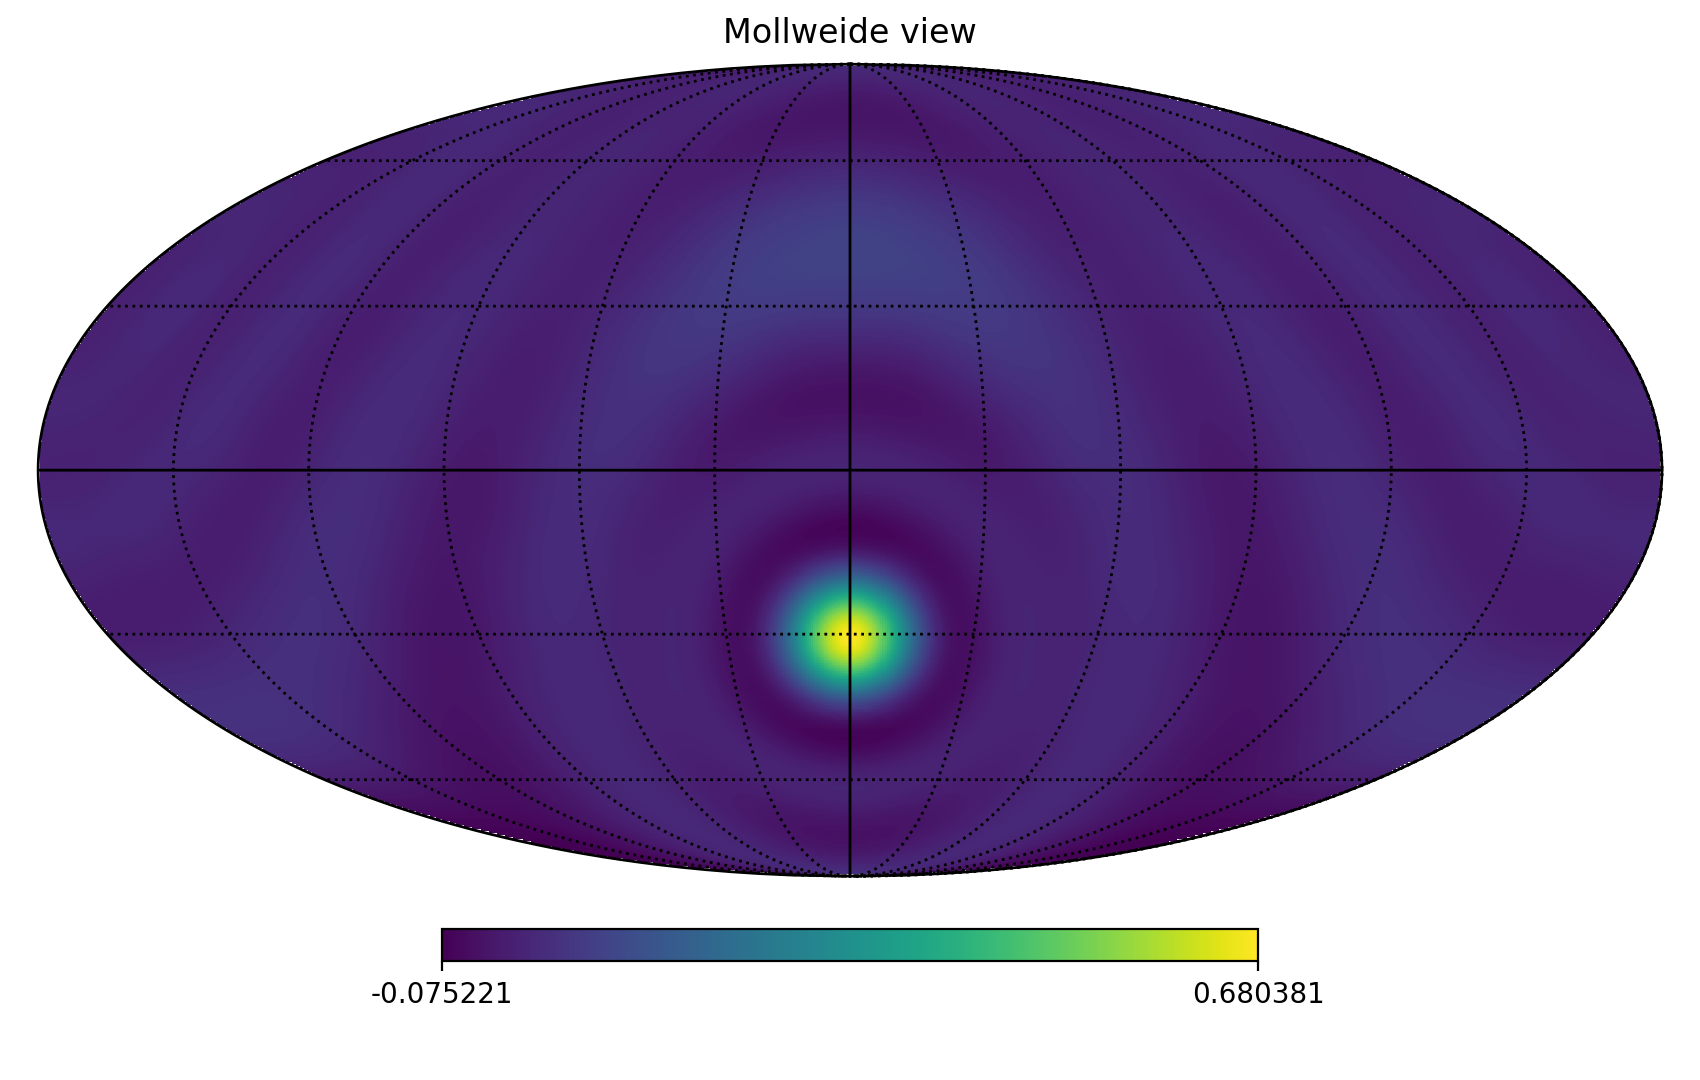

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


In [12]:
hp.mollview(test_jones[2,:,0,0])#,rot=[0,90])
hp.graticule()
plt.savefig("/Users/tashaleebillings/Desktop/research/images/00jones_across_sky.png")

hp.mollview(test_jones[2,:,0,1])#,rot=[0,90])
hp.graticule()
plt.savefig("/Users/tashaleebillings/Desktop/research/images/01jones_across_sky.png")

hp.mollview(test_jones[2,:,1,0])#,rot=[0,90])
hp.graticule()
plt.savefig("/Users/tashaleebillings/Desktop/research/images/10jones_across_sky.png")

hp.mollview(test_jones[2,:,1,1])#,rot=[0,90])
hp.graticule()
plt.savefig("/Users/tashaleebillings/Desktop/research/images/11jones_across_sky.png")

In [21]:
def PlotJonesHP(Jones):
    
    plt.figure(figsize=(10,10))
    for i in np.arange(2):
        for j in np.arange(2):
            sp = 2*i + j + 1
            plt.subplot(2,2,sp)
            #hp.orthview(Jones[:,i,j],half_sky=True,sub=(2,2,sp),cbar=False,title=' ',rot=[0,90-lat])
            hp.gnomview(Jones[:,i,j],sub=(2,2,sp),cbar=False,title=' ',rot=[0,90-lat],reso=12)
            hp.graticule()

In [22]:
# Calculcate the theta, phi corresponding to the original coordinate system

theta_hor, phi_hor = scbt.spherical_coordinates_map(R_z0, theta_flat, phi_flat)
phi_hor = 2.*np.pi - phi_hor
ijones_sq = np.reshape(J(nu_axis, theta_hor, phi_hor, R_z0.T),(len(nu_axis),npix_sq, npix_sq, 2, 2))

<IPython.core.display.Javascript object>


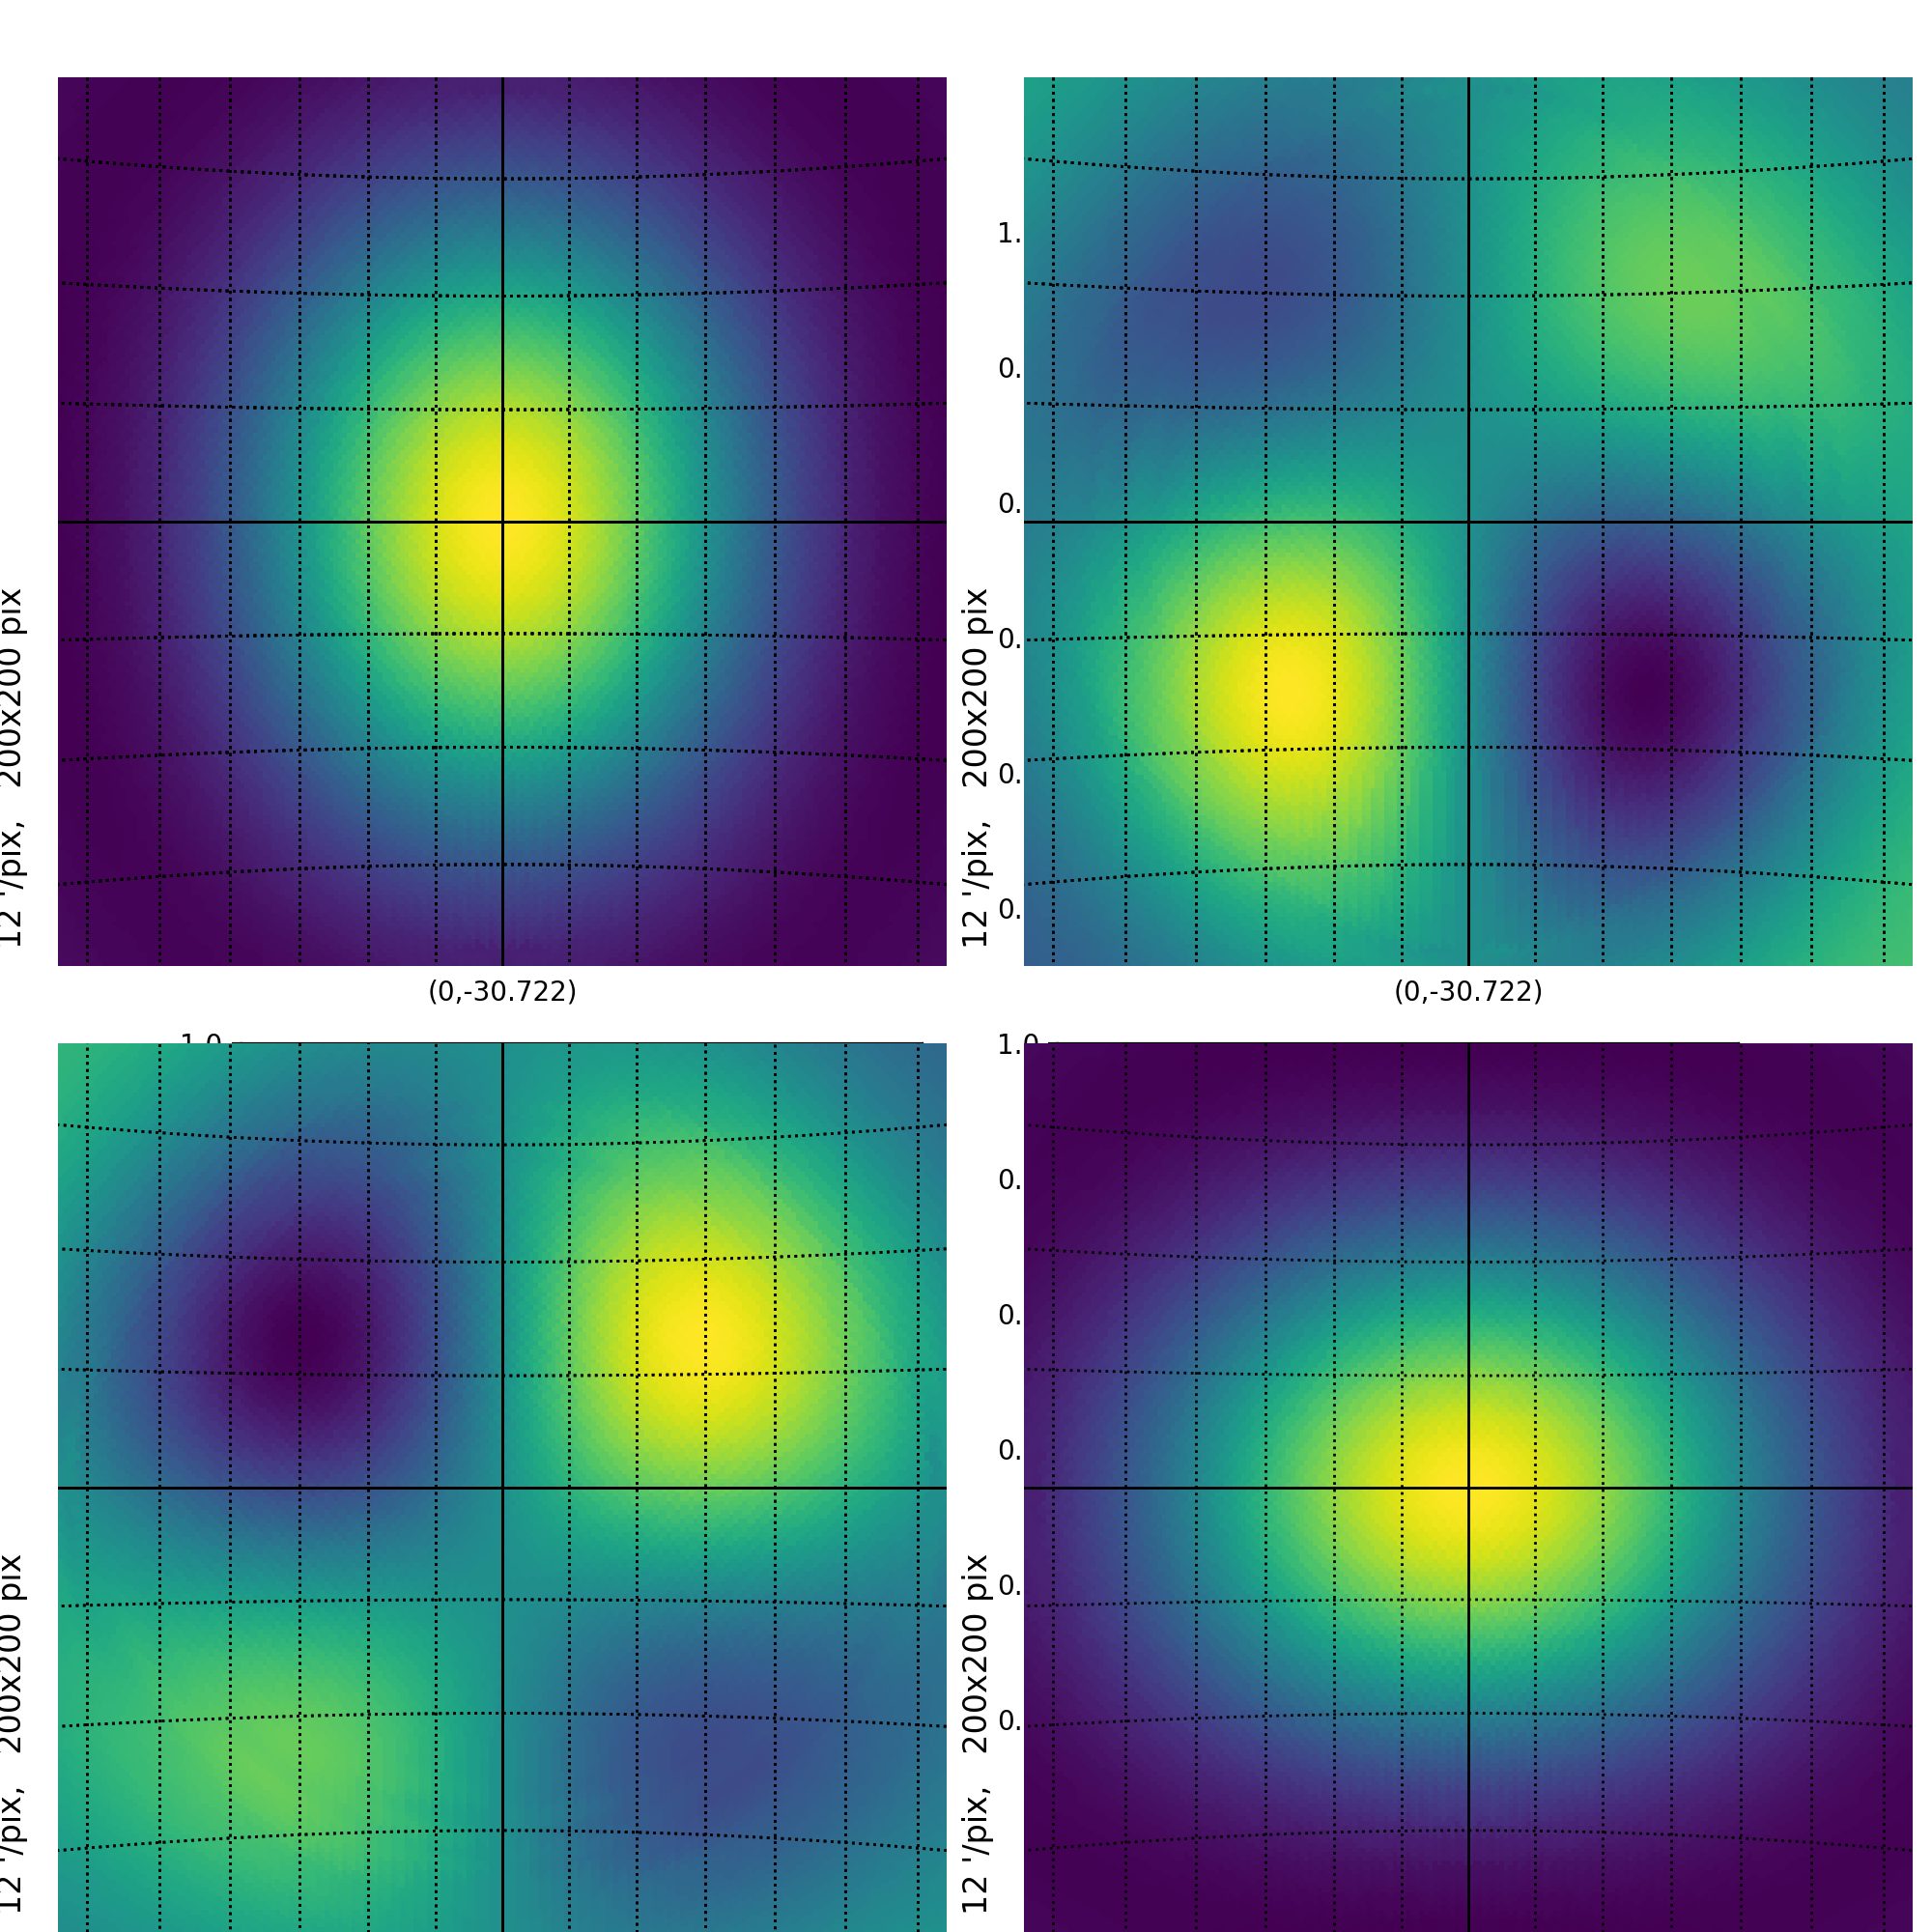

/Users/tashaleebillings/anaconda3/envs/hera2/lib/python2.7/site-packages/healpy/projector.py:201: ComplexWarning: Casting complex values to real discards the imaginary part
  img[w] = mpix


63.8404035407 116.159596459 -26.1595964593 26.1595964593
The interval between parallels is 5 deg 0.00'.
The interval between meridians is 3 deg 0.00'.
63.8404035407 116.159596459 -26.1595964593 26.1595964593
The interval between parallels is 5 deg 0.00'.
The interval between meridians is 3 deg 0.00'.
63.8404035407 116.159596459 -26.1595964593 26.1595964593
The interval between parallels is 5 deg 0.00'.
The interval between meridians is 3 deg 0.00'.
63.8404035407 116.159596459 -26.1595964593 26.1595964593
The interval between parallels is 5 deg 0.00'.
The interval between meridians is 3 deg 0.00'.
63.8404035407 116.159596459 -26.1595964593 26.1595964593
The interval between parallels is 5 deg 0.00'.
The interval between meridians is 3 deg 0.00'.
63.8404035407 116.159596459 -26.1595964593 26.1595964593
The interval between parallels is 5 deg 0.00'.
The interval between meridians is 3 deg 0.00'.
63.8404035407 116.159596459 -26.1595964593 26.1595964593
The interval between parallels is 5 d

In [23]:
# ijones has lower pixel count so that's why it don't look as good but you can still see some features.

PlotJonesHP(ijones[0,:,:,:].squeeze())

In [16]:
def PlotJones(Jones):
    
    plt.figure(figsize=(10,10))
    for i in np.arange(2):
        for j in np.arange(2):
            sp = 2*i + j + 1
            plt.subplot(2,2,sp)
            plt.imshow(np.real(Jones[:,:,i,j]), origin='lower', cmap='RdBu_r')
            plt.axhline(250, color='w', linestyle='--')
            plt.axvline(250, color='w', linestyle='--')
            plt.colorbar()
        plt.savefig('/Users/tashaleebillings/Desktop/research/images/JonesMatrix_usingAstropy.png')

<IPython.core.display.Javascript object>


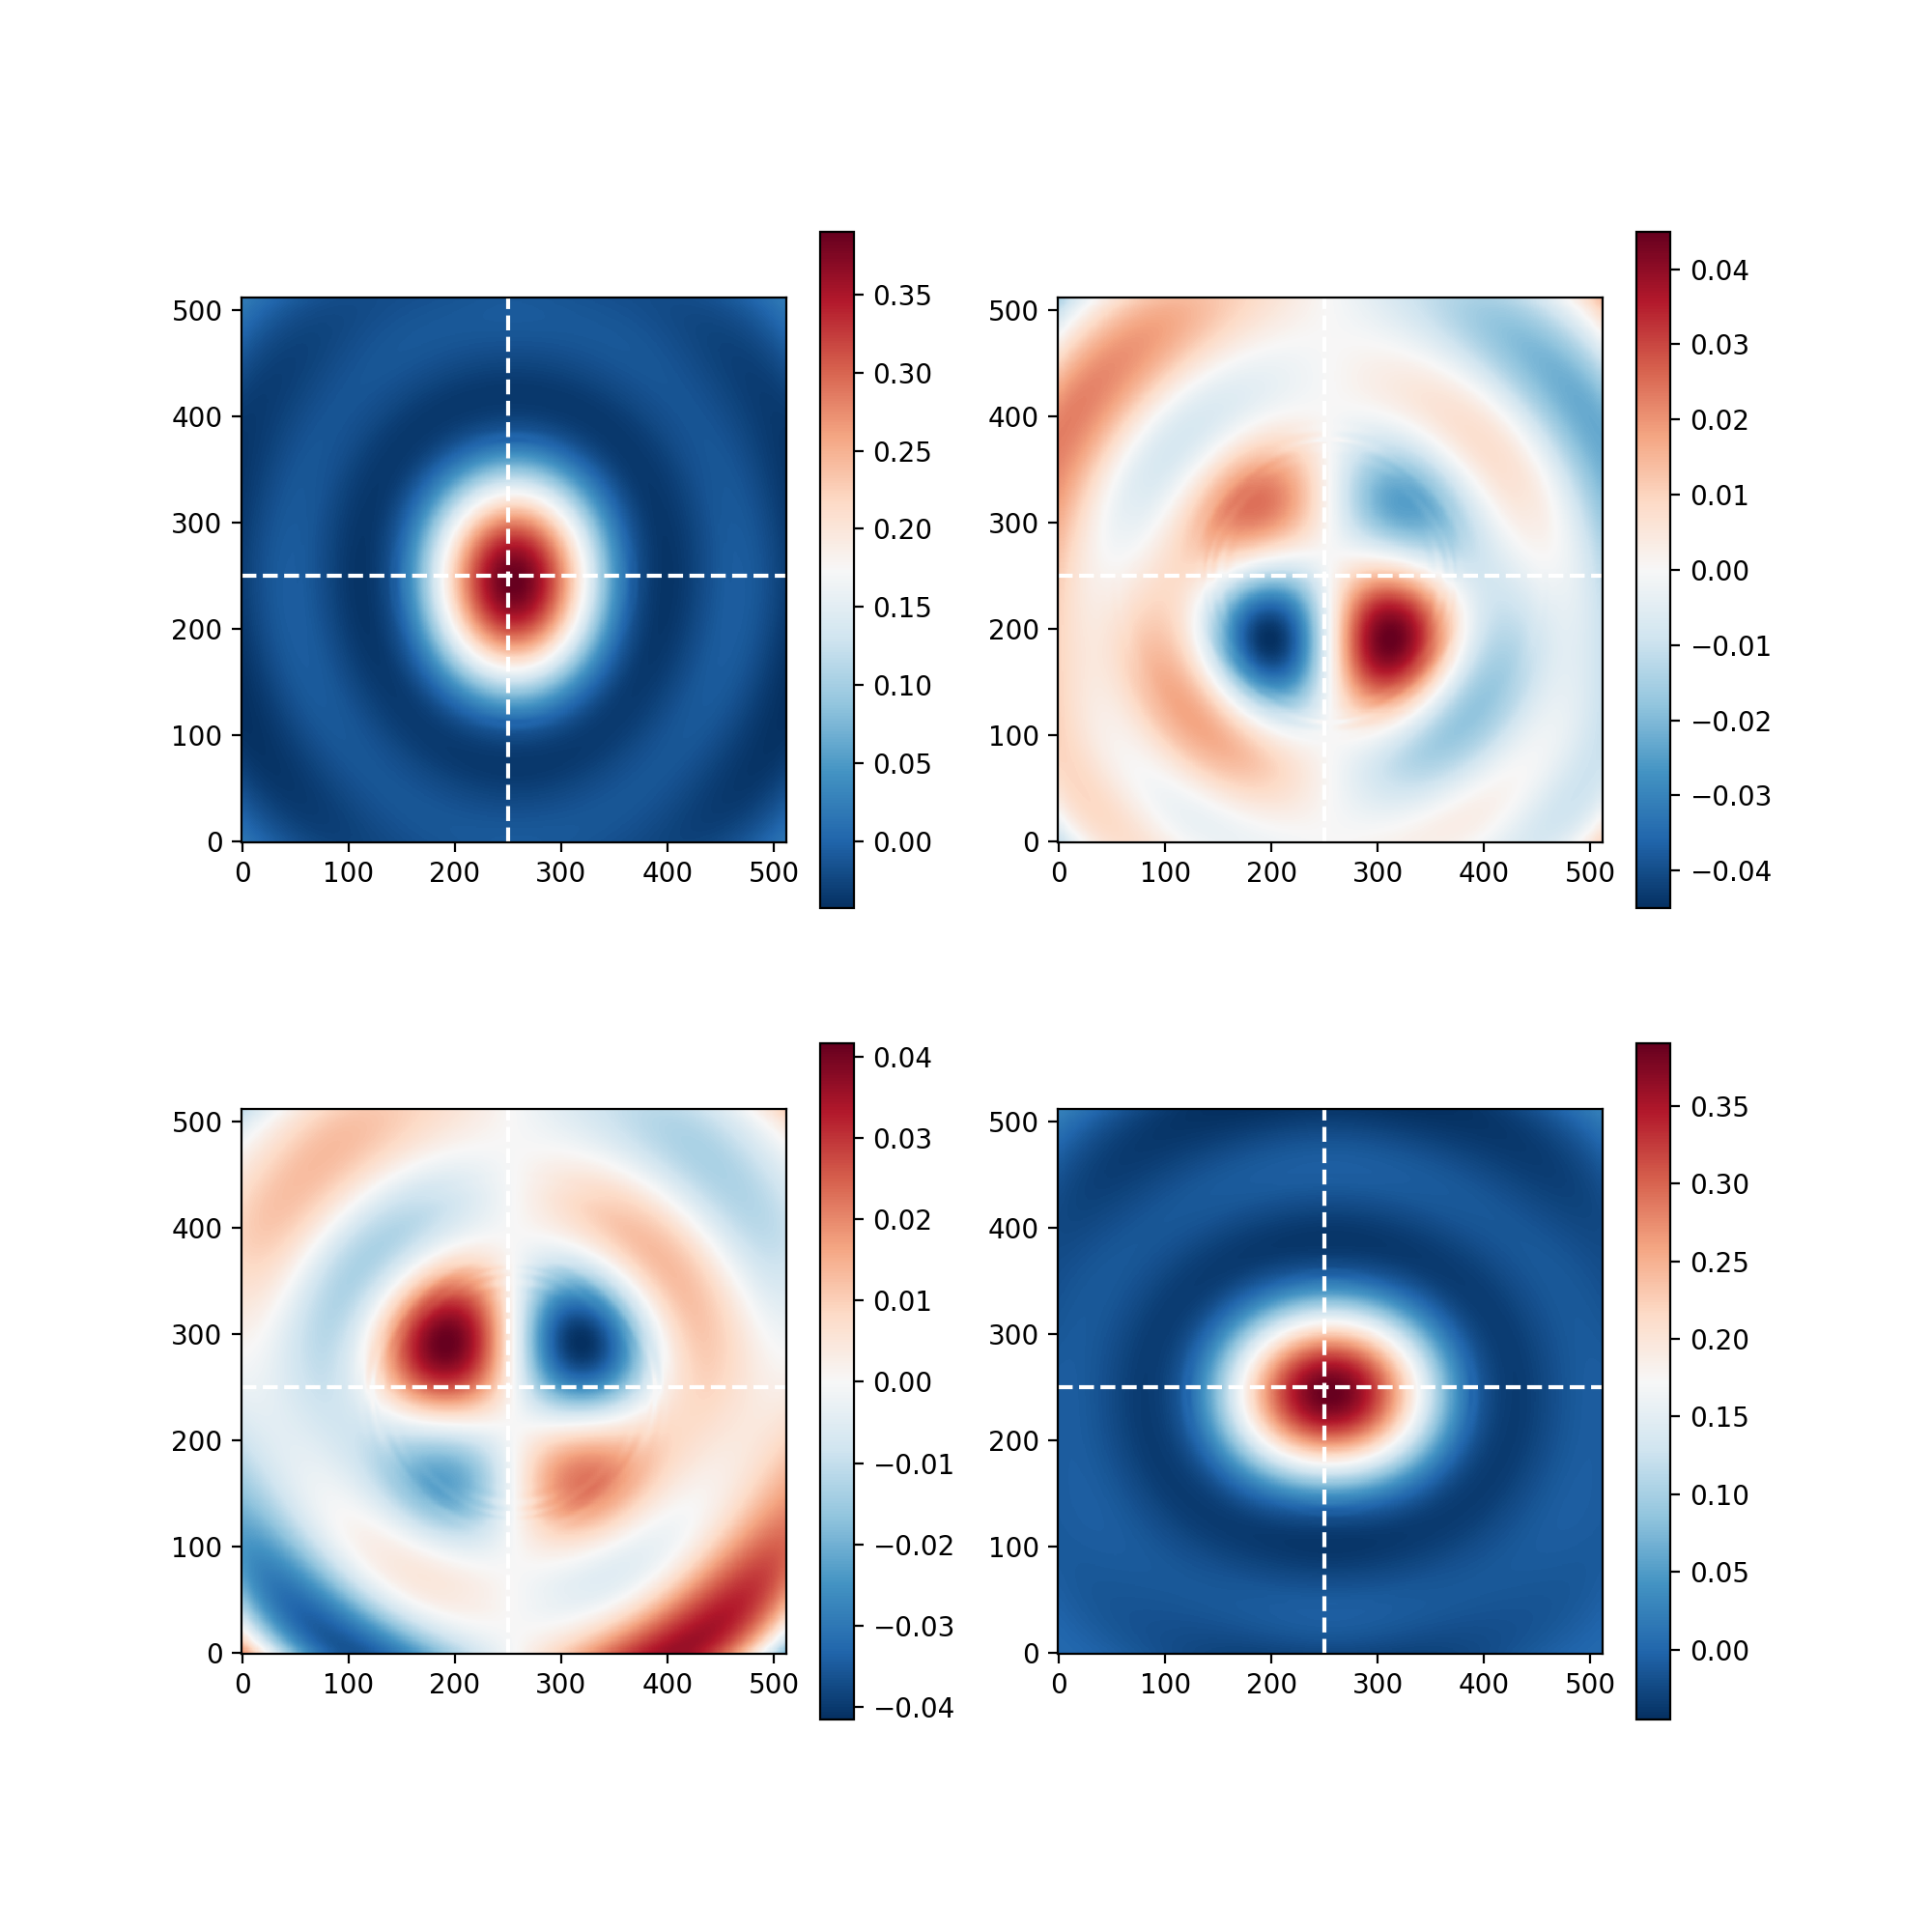

(3, 512, 512, 2, 2)


In [17]:
# ijones_sq looks much better

PlotJones(ijones_sq[0])
print ijones_sq.shape

### New Mueller Matrix

Remember, we used astropy to determine the proper coordinates.

**WARNING**: This Mueller matrix does not have the correct axis positions. It is currently *--> [i,j, freq,ra pixel,dec pixel] <--* but it needs to be *--> [ra pixel,dec pixel, freq,i,j] <--*. So you should reshape it and then you can save the data a new fits image file. I did it for you but it's commented out.

In [ ]:
# Generate Simulation of the Mueller Matrix
i_index,j_index = 4,4
nchan = len(nu_axis)
npix = 512
MuellerMatrixij_sq = np.zeros((i_index,j_index,nchan,npix,npix),dtype=np.float64) # [i,j, freq,ra pixel,dec pixel]
#new_mueller = np.zeros((512,512,3,4,4),dtype=np.float64) # [ra pixel,dec pixel, freq,i,j]

for f in range(ijones_sq.shape[0]):
    for i in range(i_index):
        for j in range(j_index):
            MuellerMatrixij_sq[i,j,f,:,:] = MuellerMatrixElement(ijones_sq[f],i,j)
            #new_mueller[:,:,f,i,j] = MuellerMatrixElement(ijones_sq[f],i,j)

In [ ]:
#PrimaryHDU
hdu = fits.PrimaryHDU(data=MuellerMatrixij_sq,header=header)
#new_hdu = fits.PrimaryHDU(data=new_mueller,header=header)
for k in header.keys():
    if k == '':
        continue
    if k == 'HISTORY':
        continue
    hdu.header.append((k,header[k]))
    #new_hdu.header.append((k,header[k]))

# write new GSM model out to a FITS file
mb_filename='/Users/tashaleebillings/Desktop/data/MuellerMatrixBeam110MHz.fits'.format(nu0)
hdu.writeto(mb_filename,overwrite=True)
mb = fits.open(mb_filename)
mb[0].header['CTYPE4']='Mueller Components' # Change the name
mb.writeto(mb_filename,overwrite=True)

<IPython.core.display.Javascript object>


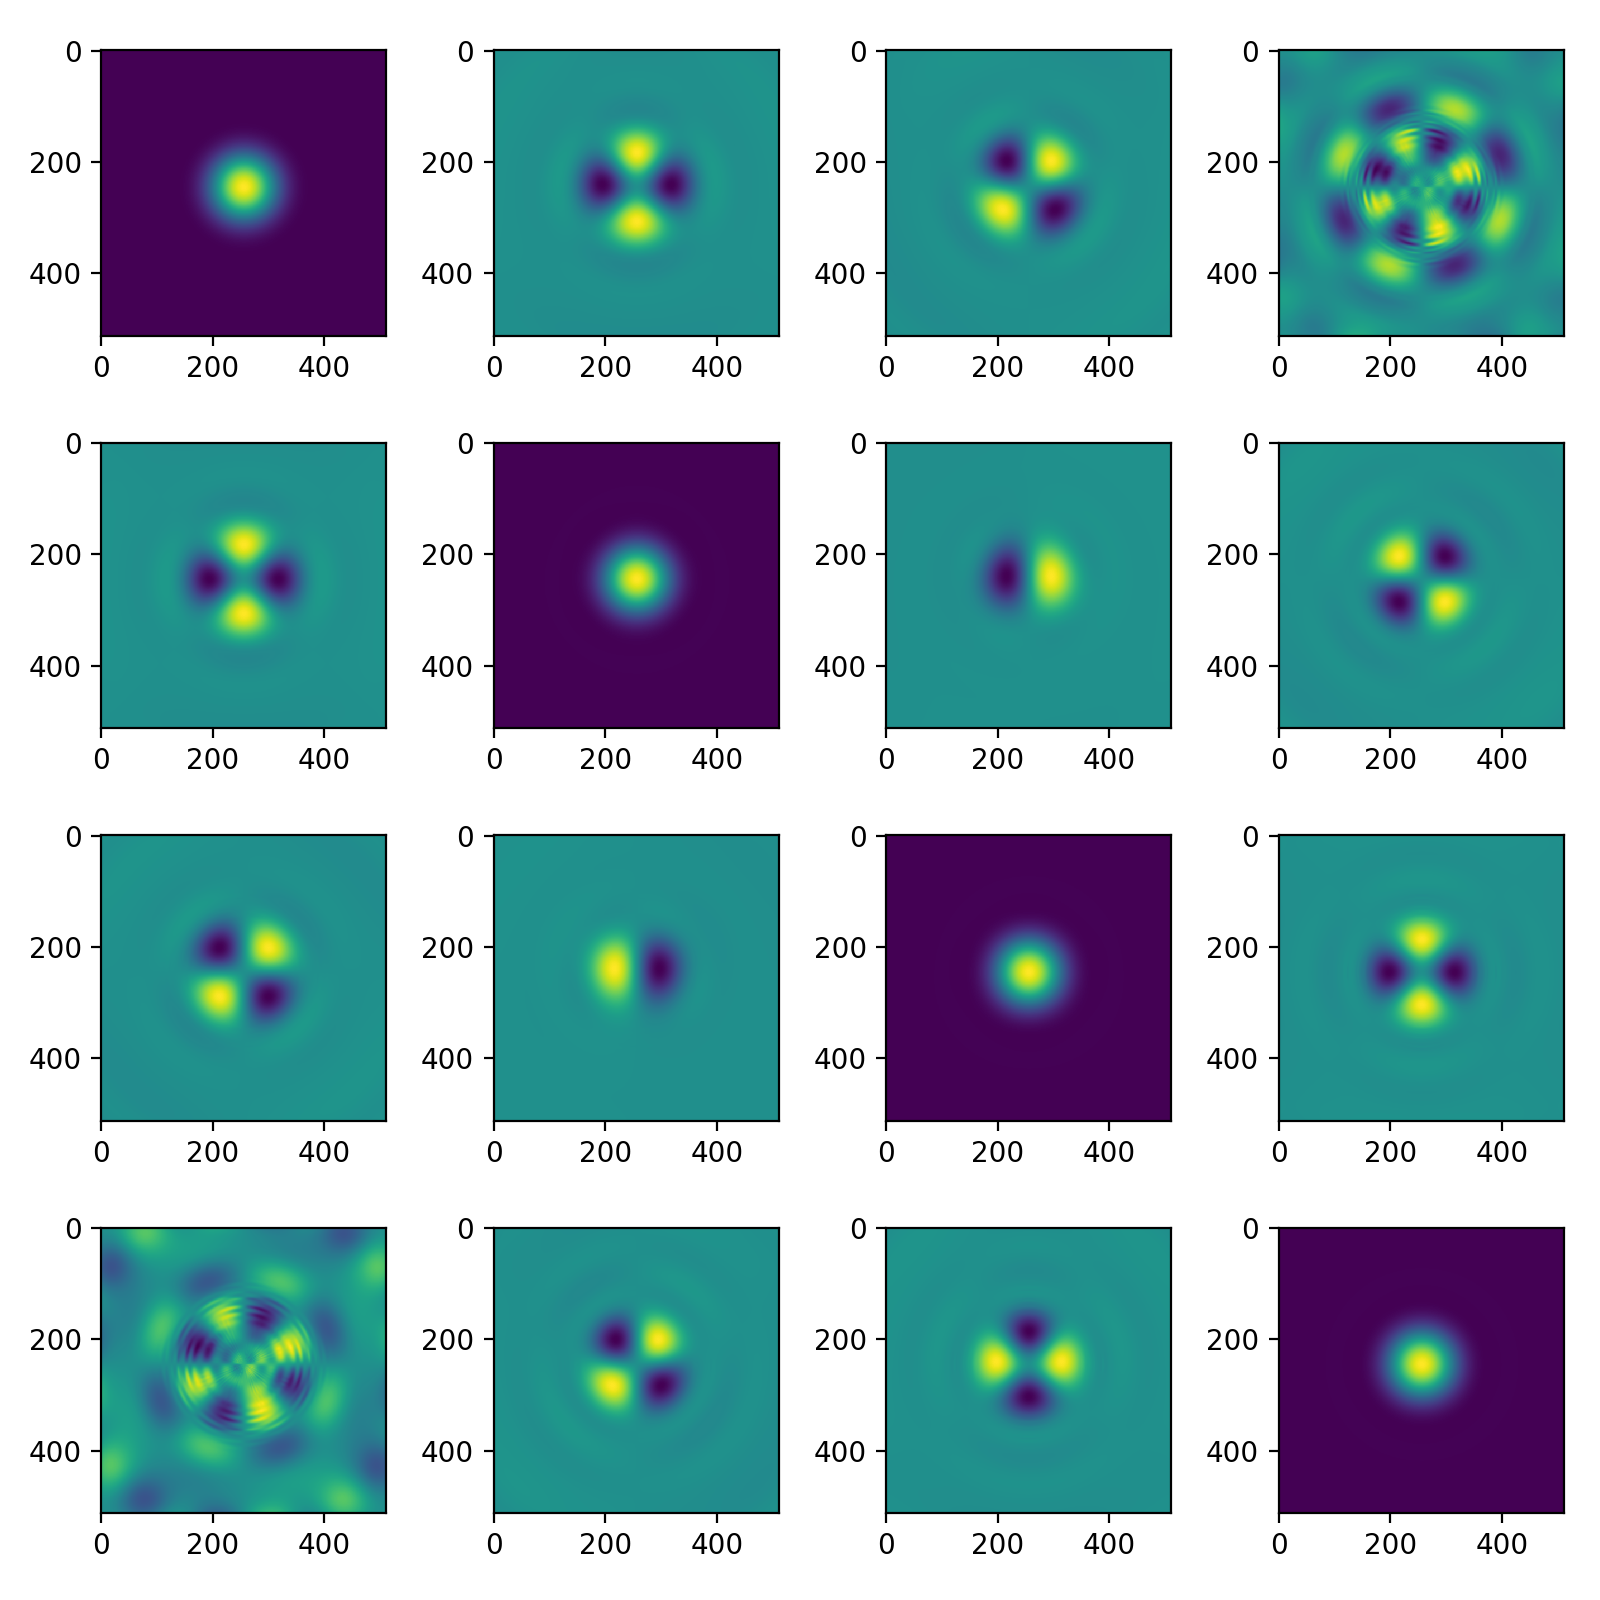

In [18]:
# Make Plot
iarr = [0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3]
jarr = [0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3]

f,axarr = plt.subplots(4,4,sharex=True,sharey=True,figsize=(8,8))
gs = gridspec.GridSpec(4,4)#, wspace=0.01, hspace=0.1)

for i in range(len(iarr)):
    
    ax=plt.subplot(gs[iarr[i],jarr[i]])
    ax.imshow(MuellerMatrixij_sq[iarr[i],jarr[i],0,:,:])
plt.tight_layout()

#f.savefig('/Users/tashaleebillings/Desktop/research/images/MuellerMatrix_usingAstropy.png')
plt.show()